# Investigation of H-DNA loci within rDNA compartments 

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile
import subprocess
from tqdm import tqdm
import os
import subprocess
from pathlib import Path
import re

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
fasta_path = Path("/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta")
telo_path = Path("/storage/group/izg5139/default/external/satellites/primates/telomeres")
gff_path = Path("/storage/group/izg5139/default/external/satellites/primates/gff")
centro_path = Path("/storage/group/izg5139/default/external/satellites/primates/centromeres")

mirror_path = Path("/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/extraction/nonbdna_primates/processed/MR")
inverted_path = Path("/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/extraction/nonbdna_primates/processed/IR")
compartment = "gene"

extract_species = lambda file: file.name.split('.')[0]
extract_species_ = lambda file: extract_species(file) if file.name.startswith("chm") else extract_species(file) + "_v2"
mirror_paths = {extract_species_(file): file for file in mirror_path.glob("*.csv")}
fasta_paths = {extract_species_(file): file for file in fasta_path.glob("*.fna.gz")}
inverted_paths = {extract_species_(file): file for file in inverted_path.glob("*.csv")}
gff_paths = {file.name.replace("-", "_").split("_")[3].split(".")[0]: file for file in gff_path.glob("*.gff.gz")}
gff_paths = {species + "_v2" if not species.startswith("CHM") else "chm13v2": file for species, file in gff_paths.items()}
centro_paths = {extract_species(file): file for file in centro_path.glob("*.bed") if "bb" not in file.name and "censat" in file.name.lower()}
telo_paths = {extract_species(file): file for file in telo_path.glob("*.bed")}
fasta_paths

{'chm13v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/chm13v2.0.fna.gz'),
 'mGorGor1_v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/mGorGor1.pri.cur.20231122.fna.gz'),
 'mPanPan1_v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/mPanPan1.pri.cur.20231122.fna.gz'),
 'mPanTro3_v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/mPanTro3.pri.cur.20231122.fna.gz'),
 'mPonAbe1_v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/mPonAbe1.pri.cur.20231205.fna.gz'),
 'mPonPyg2_v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/mPonPyg2.pri.cur.20231122.fna.gz'),
 'mSymSyn1_v2': PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/primates/fasta/mSymSyn1.pri.cur.202

# Sequence Validation

In [3]:
import gzip
from Bio import SeqIO

def parse_fasta(x, chromo=None):
    with gzip.open(x, 'rt') as g:
        for seq in SeqIO.parse(g, 'fasta'):
            yield str(seq.id), str(seq.seq).lower()

In [4]:
def load_mirror(species):
    mirror_df = pd.read_table(mirror_paths[species]).drop(columns=['#assembly_accession'])
    mirror_df.loc[:, "pyrine"] = mirror_df["sequence"].str.count("a|g").div(mirror_df["sequence"].apply(len))
    mirror_df.loc[:, "pyrimidine"] = mirror_df["sequence"].str.count("c|t").div(mirror_df["sequence"].apply(len))
    mirror_df.loc[:, "at_content"] = mirror_df["sequence"].str.count("a|t").div(mirror_df["sequence"].apply(len))
    mirror_df = mirror_df[((mirror_df['pyrine'] >= 0.9) | (mirror_df['pyrimidine'] >= 0.9)) & (mirror_df['at_content'] <= 0.8)]
    mirror_df = mirror_df.query("spacerLength < 8 & armLength > 9")
    return mirror_df

In [113]:
for species in tqdm(mirror_paths, leave=True, position=0):

    mirror = load_mirror(species)
    accession = fasta_paths[species]
    
    for seq_id, sequence in parse_fasta(accession):
        if seq_id == "chrM":
            continue
            
        temp = mirror[mirror['chromosome'] == seq_id]
        assert temp.shape[0] > 0 and len(sequence) > 0
        total_ok = 0

        for _, row in tqdm(temp.iterrows(), total=temp.shape[0], leave=True, position=0):
            
            start = int(row['start'])
            end = int(row['end'])
            
            sequenceOfArm = row['sequenceOfArm']
            sequenceOfSpacer = row['sequenceOfSpacer']
            full_sequence = row['sequence']
            sequenceLength = len(row['sequence'])
            armLength = int(row['armLength'])
            
            if isinstance(sequenceOfSpacer, float):
                sequenceOfSpacer = ""
            
            reconstructionOfMirror = sequenceOfArm + sequenceOfSpacer + sequenceOfArm[::-1]
            
            # fetch section in original sequence
            section = sequence[start: end]
            
            # has same length as sequence
            assert len(section) > 0 and start < end
            assert end - start == len(full_sequence) == len(sequenceOfSpacer) + 2 * armLength

            
            assert reconstructionOfMirror == full_sequence == section
            
            total_ok += 1
        assert total_ok == temp.shape[0] 
        print(f"Chromosome {seq_id} for species {species} HDNA coordinates have passed all checks. OK!")

100%|██████████| 14202/14202 [00:00<00:00, 14334.40it/s]


Chromosome chr1 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 13220/13220 [00:00<00:00, 14798.96it/s]


Chromosome chr2 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 10560/10560 [00:00<00:00, 14770.43it/s]


Chromosome chr3 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9439/9439 [00:00<00:00, 14810.46it/s]


Chromosome chr4 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8755/8755 [00:00<00:00, 14823.30it/s]


Chromosome chr5 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9406/9406 [00:00<00:00, 14855.08it/s]


Chromosome chr6 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 10145/10145 [00:00<00:00, 14653.54it/s]


Chromosome chr7 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8375/8375 [00:00<00:00, 14701.84it/s]


Chromosome chr8 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6697/6697 [00:00<00:00, 14834.39it/s]


Chromosome chr9 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8187/8187 [00:00<00:00, 14817.06it/s]


Chromosome chr10 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7393/7393 [00:00<00:00, 14806.14it/s]


Chromosome chr11 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8172/8172 [00:00<00:00, 14783.20it/s]


Chromosome chr12 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 16256/16256 [00:01<00:00, 14863.04it/s]


Chromosome chr13 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7263/7263 [00:00<00:00, 14716.10it/s]


Chromosome chr14 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 10443/10443 [00:00<00:00, 14788.16it/s]


Chromosome chr15 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6825/6825 [00:00<00:00, 14799.58it/s]


Chromosome chr16 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5543/5543 [00:00<00:00, 14791.77it/s]


Chromosome chr17 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 4063/4063 [00:00<00:00, 14659.94it/s]


Chromosome chr18 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6379/6379 [00:00<00:00, 14743.95it/s]


Chromosome chr19 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 4953/4953 [00:00<00:00, 14803.35it/s]


Chromosome chr20 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8945/8945 [00:00<00:00, 14707.61it/s]


Chromosome chr21 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5626/5626 [00:00<00:00, 14793.14it/s]


Chromosome chr22 for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 10777/10777 [00:00<00:00, 14654.85it/s]


Chromosome chrX for species chm13v2 HDNA coordinates have passed all checks. OK!


 14%|█▍        | 1/7 [01:34<09:26, 94.44s/it]

Chromosome chrY for species chm13v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 13615/13615 [00:00<00:00, 14653.25it/s]


Chromosome chr1_pat_hsa1 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 10006/10006 [00:00<00:00, 14754.81it/s]


Chromosome chr2_pat_hsa3 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9344/9344 [00:00<00:00, 14752.79it/s]


Chromosome chr3_pat_hsa4 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8972/8972 [00:00<00:00, 14582.27it/s]


Chromosome chr4_pat_hsa17x5 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9116/9116 [00:00<00:00, 14796.32it/s]


Chromosome chr5_mat_hsa6 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9943/9943 [00:00<00:00, 14089.32it/s]


Chromosome chr6_mat_hsa7 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8301/8301 [00:00<00:00, 14707.13it/s]


Chromosome chr7_pat_hsa8 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8055/8055 [00:00<00:00, 14789.15it/s]


Chromosome chr8_pat_hsa10 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6973/6973 [00:00<00:00, 14783.30it/s]


Chromosome chr9_pat_hsa11 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7909/7909 [00:00<00:00, 13852.88it/s]


Chromosome chr10_mat_hsa12 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6540/6540 [00:00<00:00, 14670.58it/s]


Chromosome chr11_mat_hsa2b for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6207/6207 [00:00<00:00, 14748.66it/s]


Chromosome chr12_pat_hsa2a for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6238/6238 [00:00<00:00, 14541.35it/s]


Chromosome chr13_pat_hsa9 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5264/5264 [00:00<00:00, 14741.03it/s]


Chromosome chr14_pat_hsa13 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5294/5294 [00:00<00:00, 14725.48it/s]


Chromosome chr15_pat_hsa14 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5841/5841 [00:00<00:00, 14791.56it/s]


Chromosome chr16_pat_hsa15 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 4294/4294 [00:00<00:00, 14857.32it/s]


Chromosome chr17_mat_hsa18 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7204/7204 [00:00<00:00, 14839.71it/s]


Chromosome chr18_pat_hsa16 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5093/5093 [00:00<00:00, 14721.44it/s]


Chromosome chr19_pat_hsa5x17 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6539/6539 [00:00<00:00, 14714.34it/s]


Chromosome chr20_mat_hsa19 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 4588/4588 [00:00<00:00, 14780.55it/s]


Chromosome chr21_pat_hsa20 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 3688/3688 [00:00<00:00, 14706.50it/s]


Chromosome chr22_mat_hsa21 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 3207/3207 [00:00<00:00, 14707.33it/s]


Chromosome chr23_mat_hsa22 for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 10755/10755 [00:00<00:00, 14821.77it/s]


Chromosome chrX_mat_hsaX for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


 29%|██▊       | 2/7 [03:19<08:22, 100.51s/it]

Chromosome chrY_pat_hsaY for species mGorGor1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 13464/13464 [00:00<00:00, 14530.96it/s]


Chromosome chr1_pat_hsa1 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9872/9872 [00:00<00:00, 14613.57it/s]


Chromosome chr2_mat_hsa3 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9461/9461 [00:00<00:00, 14575.71it/s]


Chromosome chr3_pat_hsa4 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8140/8140 [00:00<00:00, 13813.45it/s]


Chromosome chr4_mat_hsa5 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9019/9019 [00:00<00:00, 14435.35it/s]


Chromosome chr5_pat_hsa6 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9706/9706 [00:00<00:00, 14636.08it/s]


Chromosome chr6_mat_hsa7 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8232/8232 [00:00<00:00, 14612.38it/s]


Chromosome chr7_pat_hsa8 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7839/7839 [00:00<00:00, 14579.64it/s]


Chromosome chr8_mat_hsa10 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6696/6696 [00:00<00:00, 14538.16it/s]


Chromosome chr9_pat_hsa11 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7908/7908 [00:00<00:00, 14528.39it/s]


Chromosome chr10_mat_hsa12 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6109/6109 [00:00<00:00, 14494.70it/s]


Chromosome chr11_mat_hsa9 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6174/6174 [00:00<00:00, 14501.82it/s]


Chromosome chr12_mat_hsa2a for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6480/6480 [00:00<00:00, 14562.97it/s]


Chromosome chr13_mat_hsa2b for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6522/6522 [00:00<00:00, 14637.45it/s]


Chromosome chr14_pat_hsa13 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6355/6355 [00:00<00:00, 14651.53it/s]


Chromosome chr15_mat_hsa14 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 4608/4608 [00:00<00:00, 14445.02it/s]


Chromosome chr16_pat_hsa15 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5348/5348 [00:00<00:00, 14604.00it/s]


Chromosome chr17_mat_hsa18 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6894/6894 [00:00<00:00, 14604.17it/s]


Chromosome chr18_pat_hsa16 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5422/5422 [00:00<00:00, 14617.20it/s]


Chromosome chr19_pat_hsa17 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6456/6456 [00:00<00:00, 14466.08it/s]


Chromosome chr20_pat_hsa19 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 4668/4668 [00:00<00:00, 14555.27it/s]


Chromosome chr21_mat_hsa20 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 3016/3016 [00:00<00:00, 14552.10it/s]


Chromosome chr22_pat_hsa21 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 3774/3774 [00:00<00:00, 14730.89it/s]


Chromosome chr23_pat_hsa22 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 10729/10729 [00:00<00:00, 14041.03it/s]


Chromosome chrX_mat_hsaX for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 4900/4900 [00:00<00:00, 14440.12it/s]


Chromosome chrY_pat_hsaY for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 14/14 [00:00<00:00, 7059.42it/s]


Chromosome chr1522_pat_hsa1421_random_utig4-145 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8/8 [00:00<00:00, 8733.58it/s]


Chromosome chr1522_pat_hsa1421_random_utig4-147 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7/7 [00:00<00:00, 9115.22it/s]


Chromosome chr1522_pat_hsa1421_random_utig4-839 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 4/4 [00:00<00:00, 6523.02it/s]


Chromosome chr1522_pat_hsa1421_random_utig4-95 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


 43%|████▎     | 3/7 [04:58<06:40, 100.17s/it]

Chromosome chr1522_pat_hsa1421_random_utig4-325 for species mPanPan1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 13541/13541 [00:00<00:00, 14621.75it/s]


Chromosome chr1_hap1_hsa1 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9843/9843 [00:00<00:00, 14561.84it/s]


Chromosome chr2_hap1_hsa3 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9809/9809 [00:00<00:00, 14358.94it/s]


Chromosome chr3_hap1_hsa4 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8235/8235 [00:00<00:00, 14581.82it/s]


Chromosome chr4_hap1_hsa5 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9032/9032 [00:00<00:00, 14546.67it/s]


Chromosome chr5_hap1_hsa6 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9826/9826 [00:00<00:00, 14687.37it/s]


Chromosome chr6_hap1_hsa7 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8287/8287 [00:00<00:00, 14664.55it/s]


Chromosome chr7_hap1_hsa8 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8164/8164 [00:00<00:00, 13824.64it/s]


Chromosome chr8_hap1_hsa10 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6797/6797 [00:00<00:00, 14508.86it/s]


Chromosome chr9_hap1_hsa11 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7779/7779 [00:00<00:00, 14462.80it/s]


Chromosome chr10_hap1_hsa12 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6288/6288 [00:00<00:00, 14400.81it/s]


Chromosome chr11_hap1_hsa9 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5646/5646 [00:00<00:00, 14537.17it/s]


Chromosome chr12_hap1_hsa2a for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6481/6481 [00:00<00:00, 14558.40it/s]


Chromosome chr13_hap1_hsa2b for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6534/6534 [00:00<00:00, 14543.90it/s]


Chromosome chr14_hap1_hsa13 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6744/6744 [00:00<00:00, 14531.48it/s]


Chromosome chr15_hap1_hsa14 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 4481/4481 [00:00<00:00, 14558.74it/s]


Chromosome chr16_hap1_hsa15 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6250/6250 [00:00<00:00, 14509.50it/s]


Chromosome chr17_hap1_hsa18 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6512/6512 [00:00<00:00, 14608.17it/s]


Chromosome chr18_hap1_hsa16 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5478/5478 [00:00<00:00, 14185.92it/s]


Chromosome chr19_hap1_hsa17 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5957/5957 [00:00<00:00, 14595.12it/s]


Chromosome chr20_hap1_hsa19 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 4883/4883 [00:00<00:00, 14632.39it/s]


Chromosome chr21_hap1_hsa20 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 3066/3066 [00:00<00:00, 14554.52it/s]


Chromosome chr22_hap1_hsa21 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 3579/3579 [00:00<00:00, 14556.38it/s]


Chromosome chr23_hap1_hsa22 for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 11220/11220 [00:00<00:00, 14562.65it/s]


Chromosome chrX_hap1_hsaX for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


 57%|█████▋    | 4/7 [06:42<05:04, 101.58s/it]

Chromosome chrY_hap2_hsaY for species mPanTro3_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 12933/12933 [00:00<00:00, 14555.29it/s]


Chromosome chr1_hap1_hsa1 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9713/9713 [00:00<00:00, 14572.18it/s]


Chromosome chr2_hap1_hsa3 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9607/9607 [00:00<00:00, 14546.65it/s]


Chromosome chr3_hap1_hsa4 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8402/8402 [00:00<00:00, 14509.71it/s]


Chromosome chr4_hap1_hsa5 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9103/9103 [00:00<00:00, 14588.19it/s]


Chromosome chr5_hap1_hsa6 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 9475/9475 [00:00<00:00, 14625.06it/s]


Chromosome chr6_hap1_hsa7 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 8099/8099 [00:00<00:00, 14489.16it/s]


Chromosome chr7_hap1_hsa8 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7808/7808 [00:00<00:00, 14484.01it/s]


Chromosome chr8_hap1_hsa10 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7138/7138 [00:00<00:00, 14539.34it/s]


Chromosome chr9_hap1_hsa11 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7728/7728 [00:00<00:00, 14549.75it/s]


Chromosome chr10_hap1_hsa12 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7268/7268 [00:00<00:00, 14478.24it/s]


Chromosome chr11_hap1_hsa2b for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7477/7477 [00:00<00:00, 14548.35it/s]


Chromosome chr12_hap1_hsa2a for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 7088/7088 [00:00<00:00, 14502.03it/s]


Chromosome chr13_hap1_hsa9 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5904/5904 [00:00<00:00, 14603.91it/s]


Chromosome chr14_hap1_hsa13 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6436/6436 [00:00<00:00, 14565.64it/s]


Chromosome chr15_hap1_hsa14 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 5652/5652 [00:00<00:00, 14518.52it/s]


Chromosome chr16_hap1_hsa15 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 4771/4771 [00:00<00:00, 14434.48it/s]


Chromosome chr17_hap1_hsa18 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 6427/6427 [00:00<00:00, 12657.52it/s]


Chromosome chr18_hap1_hsa16 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


100%|██████████| 3/3 [00:00<00:00, 2059.06it/s]


Chromosome chr18_hap1_hsa16_random_utig4-1074 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


 57%|█████▋    | 4/7 [08:10<06:07, 122.51s/it]


Chromosome chr18_hap1_hsa16_random_utig4-1076 for species mPonAbe1_v2 HDNA coordinates have passed all checks. OK!


AssertionError: 

In [5]:
# mirror_df = mirror_df[mirror_df['sequence'].apply(lambda x: x.count(x[0]) != len(x))]
mirror_df = load_mirror("chm13v2")
mirror_df.head()

,chromosome,sequenceLength,armLength,composition,start,end,sequenceOfArm,sequenceOfSpacer,spacerLength,sequence,arm_a,arm_c,arm_g,arm_t,pyrine,pyrimidine,at_content
9,chr1,29,11,3A/0C/8G/0T,50042,50071,ggagggaggga,ggcagaa,7,ggagggagggaggcagaaagggagggagg,3,0,8,0,0.965517,0.034483,0.310345
10,chr1,27,10,4A/0C/6G/0T,50059,50086,aagggaggga,ggcagaa,7,aagggagggaggcagaaagggagggaa,4,0,6,0,0.962963,0.037037,0.407407
21,chr1,39,19,15A/0C/4G/0T,73390,73429,agaaagaaaaagaaagaaa,g,1,agaaagaaaaagaaagaaagaaagaaagaaaaagaaaga,15,0,4,0,1.000000,0.000000,0.769231
22,chr1,43,21,16A/0C/5G/0T,73420,73463,aaagaaagaaagaaagaaaga,a,1,aaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaa,16,0,5,0,1.000000,0.000000,0.767442
23,chr1,43,21,16A/0C/5G/0T,73422,73465,agaaagaaagaaagaaagaaa,g,1,agaaagaaagaaagaaagaaagaaagaaagaaagaaagaaaga,16,0,5,0,1.000000,0.000000,0.744186


# Load GFF Information and H-DNA repeats

In [4]:
gff_human = pd.read_table(
                        gff_paths['chm13v2'], 
                        comment="#", 
                        header=None
                    )
gff_human

,0,1,2,3,4,5,6,7,8
0,NC_060925.1,RefSeq,region,1,248387328,.,+,.,ID=NC_060925.1:1..248387328;Dbxref=taxon:9606;...
1,NC_060925.1,BestRefSeq,gene,7506,138480,.,-,.,ID=gene-LOC127239154;Dbxref=GeneID:127239154;N...
2,NC_060925.1,BestRefSeq,lnc_RNA,7506,138480,.,-,.,ID=rna-NR_182074.1;Parent=gene-LOC127239154;Db...
3,NC_060925.1,BestRefSeq,exon,138321,138480,.,-,.,ID=exon-NR_182074.1-1;Parent=rna-NR_182074.1;D...
4,NC_060925.1,BestRefSeq,exon,129906,130010,.,-,.,ID=exon-NR_182074.1-2;Parent=rna-NR_182074.1;D...
...,...,...,...,...,...,...,...,...,...
4730850,NC_060948.1,RefSeq,match,62332704,62333455,749,+,.,ID=e2de0dac-637f-40ec-aa09-10ca4ce3c4d4;Target...
4730851,NC_060948.1,RefSeq,match,62384051,62384769,719,+,.,ID=2ee6390d-f81c-40d4-a6f4-4d9d9fd4ee92;Target...
4730852,NC_060948.1,RefSeq,match,62403884,62404417,531,+,.,ID=84a80900-55d7-43a8-b3e9-1cbc782070d1;Target...
4730853,NC_060948.1,RefSeq,match,62410212,62411342,1119,+,.,ID=2be87bb9-d7c1-44df-ade4-69409d843654;Target...


In [5]:
mirror_df = pd.read_table(mirror_paths["chm13v2"]).drop(columns=['#assembly_accession'])
mirror_df.loc[:, "pyrine"] = mirror_df["sequence"].str.count("a|g").div(mirror_df["sequence"].apply(len))
mirror_df.loc[:, "pyrimidine"] = mirror_df["sequence"].str.count("c|t").div(mirror_df["sequence"].apply(len))
mirror_df.loc[:, "at_content"] = mirror_df["sequence"].str.count("a|t").div(mirror_df["sequence"].apply(len))
mirror_df = mirror_df[((mirror_df['pyrine'] >= 0.9) | (mirror_df['pyrimidine'] >= 0.9)) & (mirror_df['at_content'] <= 0.8)]
mirror_df = mirror_df.query("spacerLength < 8 & armLength > 9")

# mirror_df = mirror_df[mirror_df['sequence'].apply(lambda x: x.count(x[0]) != len(x))]
mirror_df

,chromosome,sequenceLength,armLength,composition,start,end,sequenceOfArm,sequenceOfSpacer,spacerLength,sequence,arm_a,arm_c,arm_g,arm_t,pyrine,pyrimidine,at_content
9,chr1,29,11,3A/0C/8G/0T,50042,50071,ggagggaggga,ggcagaa,7,ggagggagggaggcagaaagggagggagg,3,0,8,0,0.965517,0.034483,0.310345
10,chr1,27,10,4A/0C/6G/0T,50059,50086,aagggaggga,ggcagaa,7,aagggagggaggcagaaagggagggaa,4,0,6,0,0.962963,0.037037,0.407407
21,chr1,39,19,15A/0C/4G/0T,73390,73429,agaaagaaaaagaaagaaa,g,1,agaaagaaaaagaaagaaagaaagaaagaaaaagaaaga,15,0,4,0,1.000000,0.000000,0.769231
22,chr1,43,21,16A/0C/5G/0T,73420,73463,aaagaaagaaagaaagaaaga,a,1,aaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaa,16,0,5,0,1.000000,0.000000,0.767442
23,chr1,43,21,16A/0C/5G/0T,73422,73465,agaaagaaagaaagaaagaaa,g,1,agaaagaaagaaagaaagaaagaaagaaagaaagaaagaaaga,16,0,5,0,1.000000,0.000000,0.744186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1145817,chrY,27,13,0A/6C/0G/7T,62192836,62192863,tctctctctctct,c,1,tctctctctctctctctctctctctct,0,6,0,7,0.000000,1.000000,0.518519
1145818,chrY,27,13,0A/7C/0G/6T,62192837,62192864,ctctctctctctc,t,1,ctctctctctctctctctctctctctc,0,7,0,6,0.000000,1.000000,0.481481
1145829,chrY,22,11,7A/0C/4G/0T,62247108,62247130,aaagaaggaag,NaN,0,aaagaaggaaggaaggaagaaa,7,0,4,0,1.000000,0.000000,0.636364
1145831,chrY,28,14,5A/0C/9G/0T,62255805,62255833,aggaggaggaggag,NaN,0,aggaggaggaggaggaggaggaggagga,5,0,9,0,1.000000,0.000000,0.357143


In [6]:
human_centro = pd.read_table(
                             centro_paths['chm13v2'], 
                             usecols=range(4), 
                             names=["chromosome", "start", "end", "compartment"],
                             skiprows=1, 
                             header=None
                            )
human_centro.loc[:, "compartment"] = human_centro["compartment"].str.split("_", expand=True)[0]
rDNA = human_centro[human_centro['compartment'] == 'rDNA']
rDNA.drop(columns=['compartment'], inplace=True)
rDNA = rDNA.rename(columns={"start": "rDNA_start", 
                            "end": "rDNA_end"})
rDNA

/tmp/ipykernel_3141076/2999606114.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rDNA.drop(columns=['compartment'], inplace=True)


,chromosome,rDNA_start,rDNA_end
794,chr13,5770548,9348041
943,chr14,2099537,2817811
1161,chr15,2506442,4707485
1807,chr21,3108298,5612715
1986,chr22,4793794,5720650


In [7]:
rDNA = human_centro[human_centro['compartment'] == 'rDNA']
rDNA.columns = ['chromosome', 'rDNA_start', 'rDNA_end', 'd']
rDNA.drop(columns=['d'], inplace=True)
rDNA

/tmp/ipykernel_3141076/1273004004.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rDNA.drop(columns=['d'], inplace=True)


,chromosome,rDNA_start,rDNA_end
794,chr13,5770548,9348041
943,chr14,2099537,2817811
1161,chr15,2506442,4707485
1807,chr21,3108298,5612715
1986,chr22,4793794,5720650


# Discretize into bins the rDNA compartments

In [9]:
total_bins = 3_500
mirror_rdna = mirror_df.merge(rDNA, on="chromosome", how="inner")
mirror_rdna["start"] = mirror_rdna["start"] - mirror_rdna["rDNA_start"]
mirror_rdna["end"] = mirror_rdna["end"] - mirror_rdna["rDNA_start"]
mirror_rdna["rdna_size"] = mirror_rdna["rDNA_end"] - mirror_rdna["rDNA_start"]
mirror_rdna = mirror_rdna[(mirror_rdna["start"] >= 0) & (mirror_rdna["end"] <= mirror_rdna["rdna_size"])]

mirror_rdna.loc[:, "start_bin"] = 1 + np.floor( total_bins * mirror_rdna["start"] / mirror_rdna["rdna_size"])
mirror_rdna.loc[:, "end_bin"] = 1 + np.floor( total_bins * mirror_rdna["end"] / mirror_rdna["rdna_size"])

mirror_rdna

,chromosome,sequenceLength,armLength,composition,start,end,sequenceOfArm,sequenceOfSpacer,spacerLength,sequence,...,arm_g,arm_t,pyrine,pyrimidine,at_content,rDNA_start,rDNA_end,rdna_size,start_bin,end_bin
72,chr13,68,34,0A/10C/0G/24T,508,576,tttttcttcttcttcttcttcttcttcttcttct,NaN,0,tttttcttcttcttcttcttcttcttcttcttcttcttcttcttct...,...,0,24,0.000000,1.000000,0.705882,5770548,9348041,3577493,1.0,1.0
73,chr13,29,14,0A/7C/0G/7T,860,889,ctctctctctctct,c,1,ctctctctctctctctctctctctctctc,...,0,7,0.000000,1.000000,0.482759,5770548,9348041,3577493,1.0,1.0
74,chr13,26,10,0A/2C/0G/8T,1029,1055,ttctttcttt,ctttcg,6,ttctttctttctttcgtttctttctt,...,0,8,0.038462,0.961538,0.730769,5770548,9348041,3577493,2.0,2.0
75,chr13,23,11,0A/1C/1G/9T,1170,1193,ttgttttcttt,c,1,ttgttttctttctttcttttgtt,...,1,9,0.086957,0.913043,0.782609,5770548,9348041,3577493,2.0,2.0
76,chr13,26,10,0A/2C/0G/8T,1175,1201,ttctttcttt,cttttg,6,ttctttctttcttttgtttctttctt,...,0,8,0.038462,0.961538,0.769231,5770548,9348041,3577493,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45714,chr22,43,21,0A/5C/0G/16T,918214,918257,tctttctttctttctttcttt,c,1,tctttctttctttctttctttctttctttctttctttctttct,...,0,16,0.000000,1.000000,0.744186,4793794,5720650,926856,3468.0,3468.0
45715,chr22,33,14,0A/5C/0G/9T,918918,918951,ttctctccttcttt,aggtt,5,ttctctccttctttaggtttttcttcctctctt,...,0,9,0.090909,0.909091,0.636364,4793794,5720650,926856,3471.0,3471.0
45716,chr22,25,12,0A/9C/0G/3T,919199,919224,cctccctccctc,c,1,cctccctccctccctccctccctcc,...,0,3,0.000000,1.000000,0.240000,4793794,5720650,926856,3472.0,3472.0
45717,chr22,25,12,0A/9C/0G/3T,919201,919226,tccctccctccc,t,1,tccctccctccctccctccctccct,...,0,3,0.000000,1.000000,0.280000,4793794,5720650,926856,3472.0,3472.0


In [10]:
mirror_ch13 = mirror_df.merge(rDNA, on="chromosome", how="inner")\
                      .query("chromosome == 'chr13'")[["chromosome", "start", "end", "sequence", "spacerLength"]].reset_index(drop=True)
# mirror_ch13_next = mirror_ch13.iloc[1:, :].reset_index(drop=True)
# mirror_ch13 = mirror_ch13.merge(mirror_ch13_next, left_index=True, right_index=True)
mirror_ch13

,chromosome,start,end,sequence,spacerLength
0,chr13,5245454,5245477,ctcttctctccttctctcttctc,3
1,chr13,5255154,5255179,tctctttcttttcttttctttctct,1
2,chr13,5255168,5255189,tttctttctctctctttcttt,1
3,chr13,5255180,5255200,tctttctttcctttctttct,0
4,chr13,5259844,5259865,ttctctctctctctctctctt,1
...,...,...,...,...,...
16251,chr13,113434082,113434113,ggaaggggaggggggaggggggaggggaagg,1
16252,chr13,113434170,113434195,gggagggggagggaaagggggaggg,5
16253,chr13,113490959,113490986,ggagggaggggagggaggggagggagg,1
16254,chr13,113490966,113490988,ggggagggaggggagggagggg,0


In [107]:
# gff_human_chr13.to_csv(f"{save_at}/chr13.bed", sep="\t", header=None, mode="w", index=False)

# mirror_ch13.query("spacerLength == 1")[["chromosome", "start", "end", "sequence"]]\
#                                         .to_csv(f"{save_at}/mirror_chr13.bed", 
#                                                 sep="\t", 
#                                                 header=None, 
#                                                 mode="w", 
#                                                 index=False
#                                             )

# intersect = f"{save_at}/chr13.intersect.bed"
# command = f"bedtools intersect -a {save_at}/chr13.bed -b {save_at}/mirror_chr13.bed -wo > {intersect}" 
# subprocess.run(command, shell=True, check=True)

# inter_df = pd.read_table(intersect, names=["chromosome", "start", "end", "seq_id", "mstart", "mend", "sequence", "overlap"], header=None)
# inter_df.loc[:, "mstart_norm"] = inter_df["mstart"] - inter_df["start"]
# inter_df.loc[:, "mend_norm"] = inter_df["mend"] - inter_df["start"]
# grouped_sequences = inter_df.groupby(["start", "end"], as_index=False).agg({"sequence": lambda ds: ds.tolist()})
# grouped_sequences.head(40)

In [12]:
mirror_counts = mirror_rdna.groupby(["chromosome", "start_bin", "end_bin"], as_index=False)\
                        .agg(totalCounts=("armLength", "count"))

chromosomes = mirror_counts['chromosome'].unique()
bin_counts = {}
for chromo in chromosomes:
    bin_counts.update({chromo: np.zeros(total_bins)})

for _, row in mirror_counts.iterrows():
    start = int(row['start_bin'])
    end = int(row['end_bin'])
    chromosome = row['chromosome']
    counts = row['totalCounts']
    # spacer = row['spacerLength']

    for i in range(start, end+1):
        bin_counts[chromosome][i-1] += counts

In [13]:
human_chromosomes = {1: 'NC_060925.1',
                2: 'NC_060926.1',	
                3: 'NC_060927.1',
                4: 'NC_060928.1',
                5: 'NC_060929.1',
                6: 'NC_060930.1',
                7: 'NC_060931.1',
                8: 'NC_060932.1',
                9: 'NC_060933.1',	
                10: 'NC_060934.1',	
                11: 'NC_060935.1',	
                12: 'NC_060936.1',		
                13: 'NC_060937.1',	
                14: 'NC_060938.1',
                15: 'NC_060939.1',		
                16: 'NC_060940.1',		
                17: 'NC_060941.1',	
                18: 'NC_060942.1',	
                19: 'NC_060943.1',	
                20: 'NC_060944.1',	
                21: 'NC_060945.1',	
                22: 'NC_060946.1',	
                'X': 'NC_060947.1',
                'Y': 'NC_060948.1',
             }
human_chromosomes = {v: f'chr{k}' for k, v in human_chromosomes.items()}
human_chromosomes

{'NC_060925.1': 'chr1',
 'NC_060926.1': 'chr2',
 'NC_060927.1': 'chr3',
 'NC_060928.1': 'chr4',
 'NC_060929.1': 'chr5',
 'NC_060930.1': 'chr6',
 'NC_060931.1': 'chr7',
 'NC_060932.1': 'chr8',
 'NC_060933.1': 'chr9',
 'NC_060934.1': 'chr10',
 'NC_060935.1': 'chr11',
 'NC_060936.1': 'chr12',
 'NC_060937.1': 'chr13',
 'NC_060938.1': 'chr14',
 'NC_060939.1': 'chr15',
 'NC_060940.1': 'chr16',
 'NC_060941.1': 'chr17',
 'NC_060942.1': 'chr18',
 'NC_060943.1': 'chr19',
 'NC_060944.1': 'chr20',
 'NC_060945.1': 'chr21',
 'NC_060946.1': 'chr22',
 'NC_060947.1': 'chrX',
 'NC_060948.1': 'chrY'}

In [14]:
gff_human = pd.read_table(
                        gff_paths['chm13v2'], 
                        comment="#", 
                        header=None,
                        names=["seq_id", "source", "compartment", "start", "end", "score", "strand", "phase", "attributes"],
                )

gff_human["start"] = gff_human['start'] - 1
gff_human = gff_human[gff_human['compartment'] == "gene"]
gff_human = gff_human[gff_human['attributes'].str.contains("gene_biotype=rRNA")][["seq_id", "start", "end", "attributes"]]
gff_human["seq_id"] = gff_human["seq_id"].apply(lambda y: human_chromosomes[y])
# gff_human["seq_id"] = gff_human["seq_id"].apply(lambda y: int(re.search("NC_\d\d\d\d(\d\d)\.\d", y).group(1)) - 24)
# gff_human["seq_id"] = gff_human["seq_id"].apply(lambda y: {23: 'chrX', 24: 'chrY'}.get(y, f'chr{y}'))
gff_human.drop(columns=["attributes"], inplace=True)
gff_human = gff_human[gff_human['seq_id'] != 'chr1']
gff_human

,seq_id,start,end
3136618,chr13,5777957,5779826
3136621,chr13,5780909,5781062
3136624,chr13,5782235,5787318
3136631,chr13,5871897,5873766
3136634,chr13,5874849,5875002
...,...,...,...
4439946,chr22,5672658,5674527
4439949,chr22,5675595,5675748
4439952,chr22,5676921,5681977
4439960,chr22,5717996,5719865


In [15]:
save_at = Path("/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/extraction")

In [34]:
import pybedtools
from pybedtools import BedTool
pybedtools.helpers.set_bedtools_path('/storage/group/izg5139/default/nicole/miniconda3/bin')
pybedtools.set_tempdir("/storage/home/nmc6088/scratch")

In [35]:
a = pybedtools.BedTool.from_dataframe(gff_human[["seq_id", "start", "end"]])
a

<BedTool(/storage/home/nmc6088/scratch/pybedtools.kwapbts7.tmp)>

In [36]:
merged_gff = a.merge(c="3", o="count")\
            .to_dataframe()\
            .rename(columns={"name": "counts"})
merged_gff.loc[:, "length"] = merged_gff["end"] - merged_gff["start"]
rRNA_classes = {'15': 'small',
                '18': 'medium',
                '50': 'large',
                '13': 'gigantic'
               }
merged_gff.loc[:, 'rRNA_class'] = merged_gff['length'].apply(lambda y: rRNA_classes[str(y)[:2]])
merged_gff

,chrom,start,end,counts,length,rRNA_class
0,chr13,5777957,5779826,1,1869,medium
1,chr13,5780909,5781062,1,153,small
2,chr13,5782235,5787318,1,5083,large
3,chr13,5871897,5873766,1,1869,medium
4,chr13,5874849,5875002,1,153,small
...,...,...,...,...,...,...
632,chr22,5672658,5674527,1,1869,medium
633,chr22,5675595,5675748,1,153,small
634,chr22,5676921,5681977,1,5056,large
635,chr22,5717996,5719865,1,1869,medium


In [37]:
with tempfile.NamedTemporaryFile(dir=save_at) as gff_file, tempfile.NamedTemporaryFile(dir=save_at) as gff_merged:
    gff_human[["seq_id", "start", "end"]].to_csv(
                                                               gff_file, 
                                                               sep="\t", 
                                                               index=False, 
                                                               header=None, 
                                                               mode="w"
                                                              )
    command = f"bedtools merge -i {gff_file.name} -c 3 -o count > {gff_merged.name}"
    subprocess.run(command, shell=True, check=True)
    merged_gff = pd.read_table(gff_merged, header=None, names=["seq_id", "start", "end", "counts"])
    merged_gff.loc[:, "length"] = merged_gff["end"] - merged_gff["start"]
    rRNA_classes = {'15': 'small',
                    '18': 'medium',
                    '50': 'large',
                    '13': 'gigantic'
                   }
    merged_gff.loc[:, 'rRNA_class'] = merged_gff['length'].apply(lambda y: rRNA_classes[str(y)[:2]])
    print(merged_gff.rRNA_class.value_counts())
    
merged_gff

rRNA_class
small       214
medium      212
large       208
gigantic      3
Name: count, dtype: int64


,seq_id,start,end,counts,length,rRNA_class
0,chr13,5777957,5779826,1,1869,medium
1,chr13,5780909,5781062,1,153,small
2,chr13,5782235,5787318,1,5083,large
3,chr13,5871897,5873766,1,1869,medium
4,chr13,5874849,5875002,1,153,small
...,...,...,...,...,...,...
632,chr22,5672658,5674527,1,1869,medium
633,chr22,5675595,5675748,1,153,small
634,chr22,5676921,5681977,1,5056,large
635,chr22,5717996,5719865,1,1869,medium


In [38]:
merged_gff = merged_gff.reset_index(drop=True)
merged_gff_next = merged_gff.iloc[1:, :].reset_index(drop=True)

In [39]:
merged_human = merged_gff.merge(rDNA, 
                               left_on="seq_id", 
                               right_on="chromosome", 
                               how="inner")\
                        .merge(
                            merged_gff_next[["seq_id", "start", "rRNA_class"]]\
                                            .rename(columns={"start": "next_start",  "rRNA_class": "next_rRNA_class"}),
                            how="left",
                            left_index=True,
                            right_index=True
                        ).query("seq_id_x == seq_id_y")
merged_human.loc[:, "gap_length"] = merged_human["next_start"] - merged_human["end"]
merged_human

,seq_id_x,start,end,counts,length,rRNA_class,chromosome,rDNA_start,rDNA_end,seq_id_y,next_start,next_rRNA_class,gap_length
0,chr13,5777957,5779826,1,1869,medium,chr13,5770548,9348041,chr13,5780909.0,small,1083.0
1,chr13,5780909,5781062,1,153,small,chr13,5770548,9348041,chr13,5782235.0,large,1173.0
2,chr13,5782235,5787318,1,5083,large,chr13,5770548,9348041,chr13,5871897.0,medium,84579.0
3,chr13,5871897,5873766,1,1869,medium,chr13,5770548,9348041,chr13,5874849.0,small,1083.0
4,chr13,5874849,5875002,1,153,small,chr13,5770548,9348041,chr13,5876175.0,large,1173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,chr22,5631620,5636656,1,5036,large,chr22,4793794,5720650,chr22,5672658.0,medium,36002.0
632,chr22,5672658,5674527,1,1869,medium,chr22,4793794,5720650,chr22,5675595.0,small,1068.0
633,chr22,5675595,5675748,1,153,small,chr22,4793794,5720650,chr22,5676921.0,large,1173.0
634,chr22,5676921,5681977,1,5056,large,chr22,4793794,5720650,chr22,5717996.0,medium,36019.0


In [40]:
with tempfile.NamedTemporaryFile(dir=save_at) as gff_file, tempfile.NamedTemporaryFile(dir=save_at) as gff_merged:
    gff_human[["seq_id", "start", "end"]].to_csv(
                                                               gff_file, 
                                                               sep="\t", 
                                                               index=False, 
                                                               header=None, 
                                                               mode="w"
                                                              )
    command = f"bedtools merge -i {gff_file.name} -c 3 -o count > {gff_merged.name}"
    subprocess.run(command, shell=True, check=True)
    merged = pd.read_table(gff_merged, header=None, names=["seq_id", "start", "end", "counts"])
    
merged

,seq_id,start,end,counts
0,chr13,5777957,5779826,1
1,chr13,5780909,5781062,1
2,chr13,5782235,5787318,1
3,chr13,5871897,5873766,1
4,chr13,5874849,5875002,1
...,...,...,...,...
632,chr22,5672658,5674527,1
633,chr22,5675595,5675748,1
634,chr22,5676921,5681977,1
635,chr22,5717996,5719865,1


In [41]:
merged_gff_norm = merged_human.copy()

merged_gff_norm["ustart"] = merged_gff_norm["start"]
merged_gff_norm["uend"] = merged_gff_norm["end"]
merged_gff_norm["start"] = merged_gff_norm["start"] - merged_gff_norm["rDNA_start"] 
merged_gff_norm["end"] = merged_gff_norm["end"] - merged_gff_norm["rDNA_start"]
merged_gff_norm["rdna_size"] = merged_gff_norm["rDNA_end"] - merged_gff_norm["rDNA_start"]

merged_gff_norm = merged_gff_norm[(merged_gff_norm["start"] >= 0) & (merged_gff_norm["end"] <= merged_gff_norm["rdna_size"])]

merged_gff_norm.loc[:, "start_bin"] = 1 + np.floor( total_bins * merged_gff_norm["start"] / merged_gff_norm["rdna_size"])
merged_gff_norm.loc[:, "end_bin"] = 1 + np.floor( total_bins * merged_gff_norm["end"] / merged_gff_norm["rdna_size"])
merged_gff_norm

,seq_id_x,start,end,counts,length,rRNA_class,chromosome,rDNA_start,rDNA_end,seq_id_y,next_start,next_rRNA_class,gap_length,ustart,uend,rdna_size,start_bin,end_bin
0,chr13,7409,9278,1,1869,medium,chr13,5770548,9348041,chr13,5780909.0,small,1083.0,5777957,5779826,3577493,8.0,10.0
1,chr13,10361,10514,1,153,small,chr13,5770548,9348041,chr13,5782235.0,large,1173.0,5780909,5781062,3577493,11.0,11.0
2,chr13,11687,16770,1,5083,large,chr13,5770548,9348041,chr13,5871897.0,medium,84579.0,5782235,5787318,3577493,12.0,17.0
3,chr13,101349,103218,1,1869,medium,chr13,5770548,9348041,chr13,5874849.0,small,1083.0,5871897,5873766,3577493,100.0,101.0
4,chr13,104301,104454,1,153,small,chr13,5770548,9348041,chr13,5876175.0,large,1173.0,5874849,5875002,3577493,103.0,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,chr22,837826,842862,1,5036,large,chr22,4793794,5720650,chr22,5672658.0,medium,36002.0,5631620,5636656,926856,3164.0,3183.0
632,chr22,878864,880733,1,1869,medium,chr22,4793794,5720650,chr22,5675595.0,small,1068.0,5672658,5674527,926856,3319.0,3326.0
633,chr22,881801,881954,1,153,small,chr22,4793794,5720650,chr22,5676921.0,large,1173.0,5675595,5675748,926856,3330.0,3331.0
634,chr22,883127,888183,1,5056,large,chr22,4793794,5720650,chr22,5717996.0,medium,36019.0,5676921,5681977,926856,3335.0,3354.0


In [42]:
umapping = {}

for chromosome in merged_gff_norm["chromosome"].unique():
    print(chromosome)
    temp = merged_gff_norm[merged_gff_norm['chromosome'] == chromosome]
    temp2 = rDNA[rDNA['chromosome'] == chromosome].rename(columns={"rDNA_start": "start", "rDNA_end": "end"})
    temp2["start_bin"] = 0
    temp2["end_bin"] = total_bins
    umapping.update({chromosome: temp[["ustart", "start_bin"]].set_index("start_bin")["ustart"].to_dict() | temp[["uend", "end_bin"]].set_index("end_bin")["uend"].to_dict() | temp2[["start", "start_bin"]].set_index("start_bin")["start"].to_dict() | temp2[["end", "end_bin"]].set_index("end_bin")["end"].to_dict()
                    })
    
len(umapping)

chr13
chr14
chr15
chr21
chr22


5

In [43]:
save_at

PosixPath('/storage/group/izg5139/default/external/quadrupia_database/g4/nonBDNA/extraction')

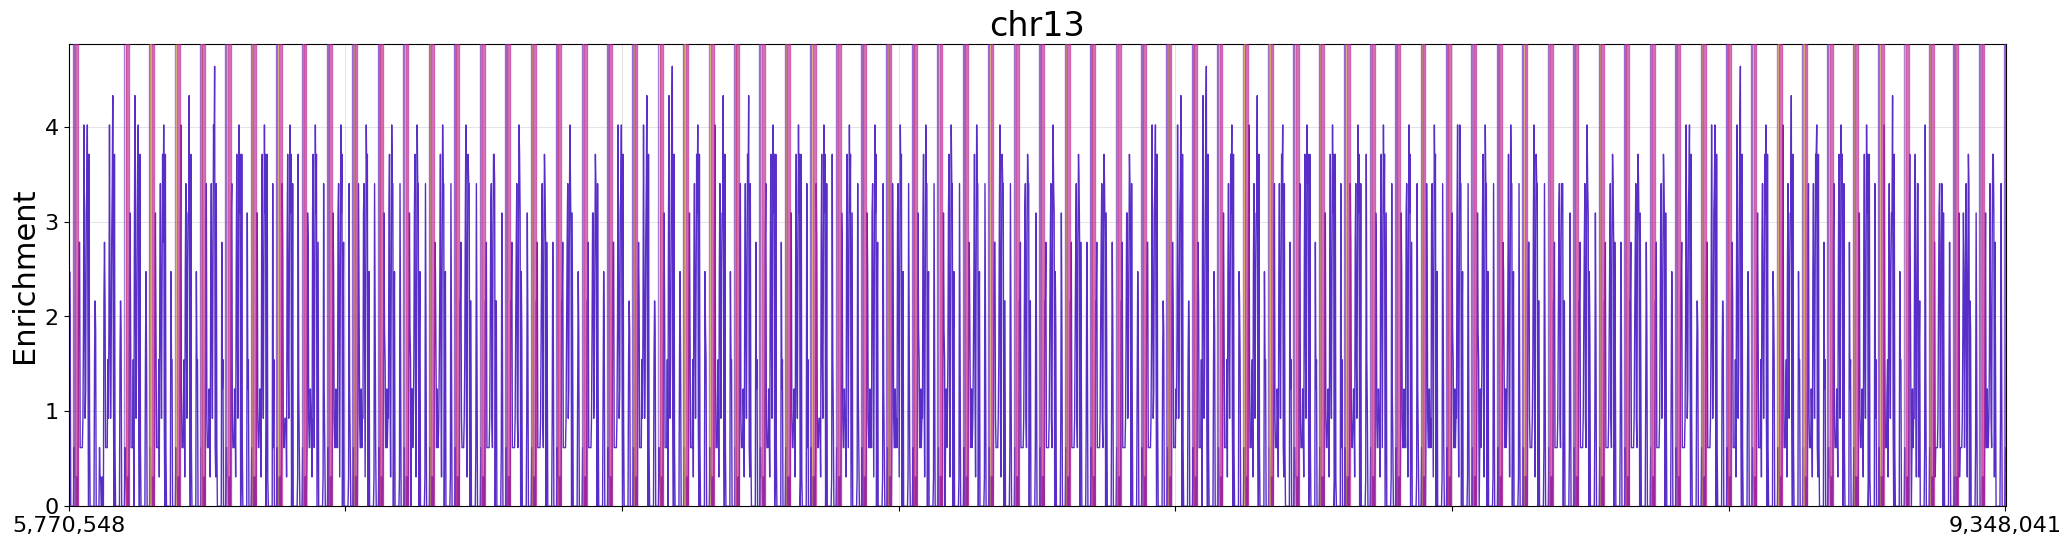

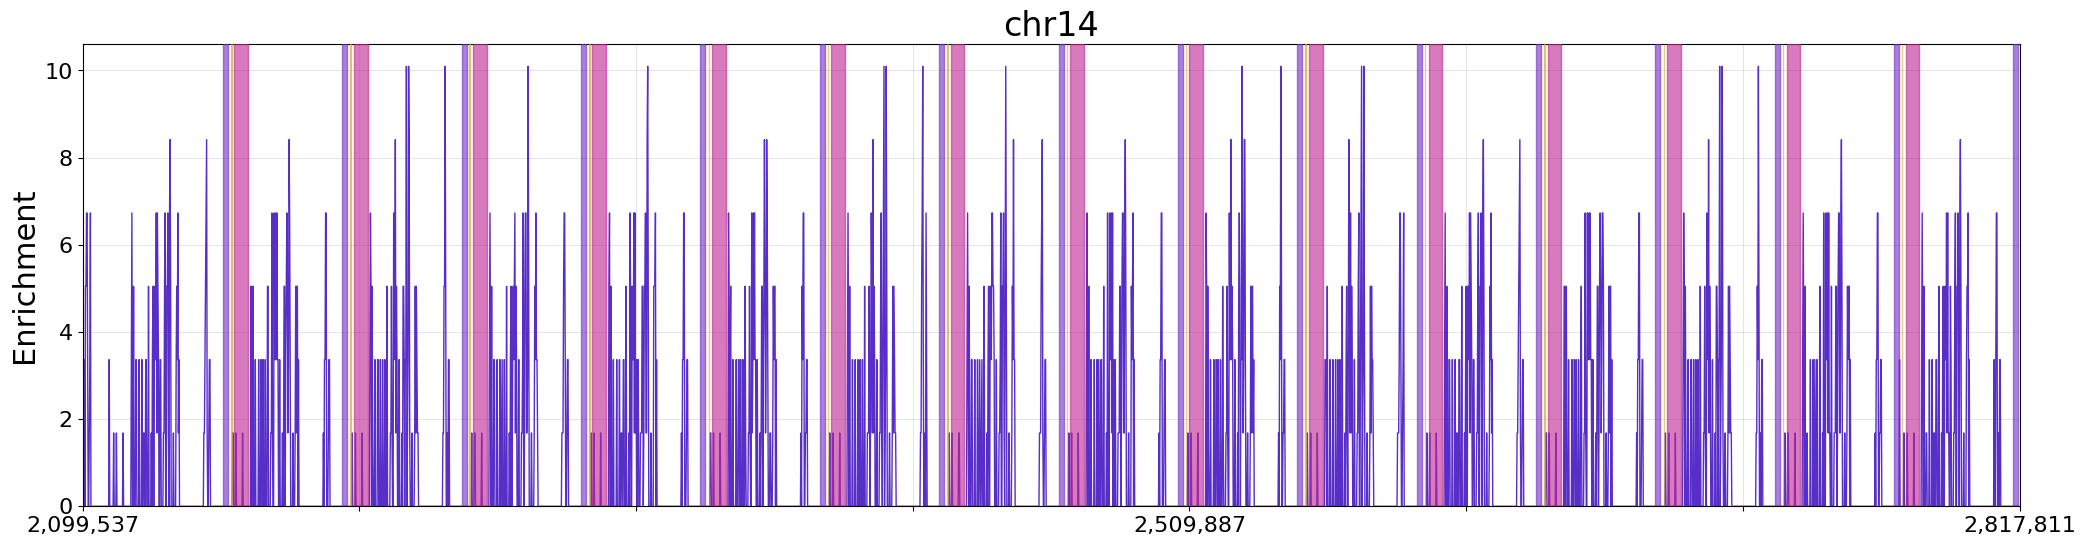

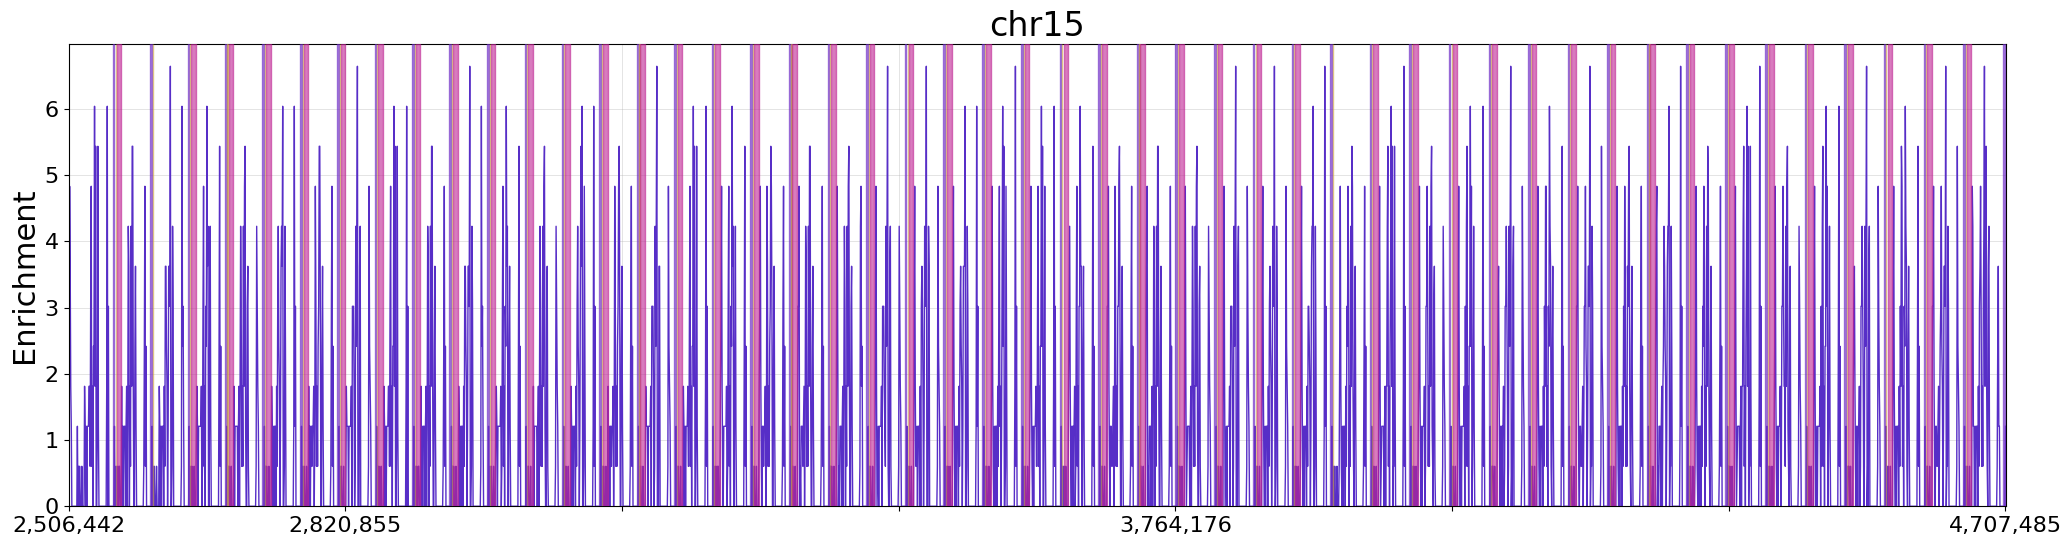

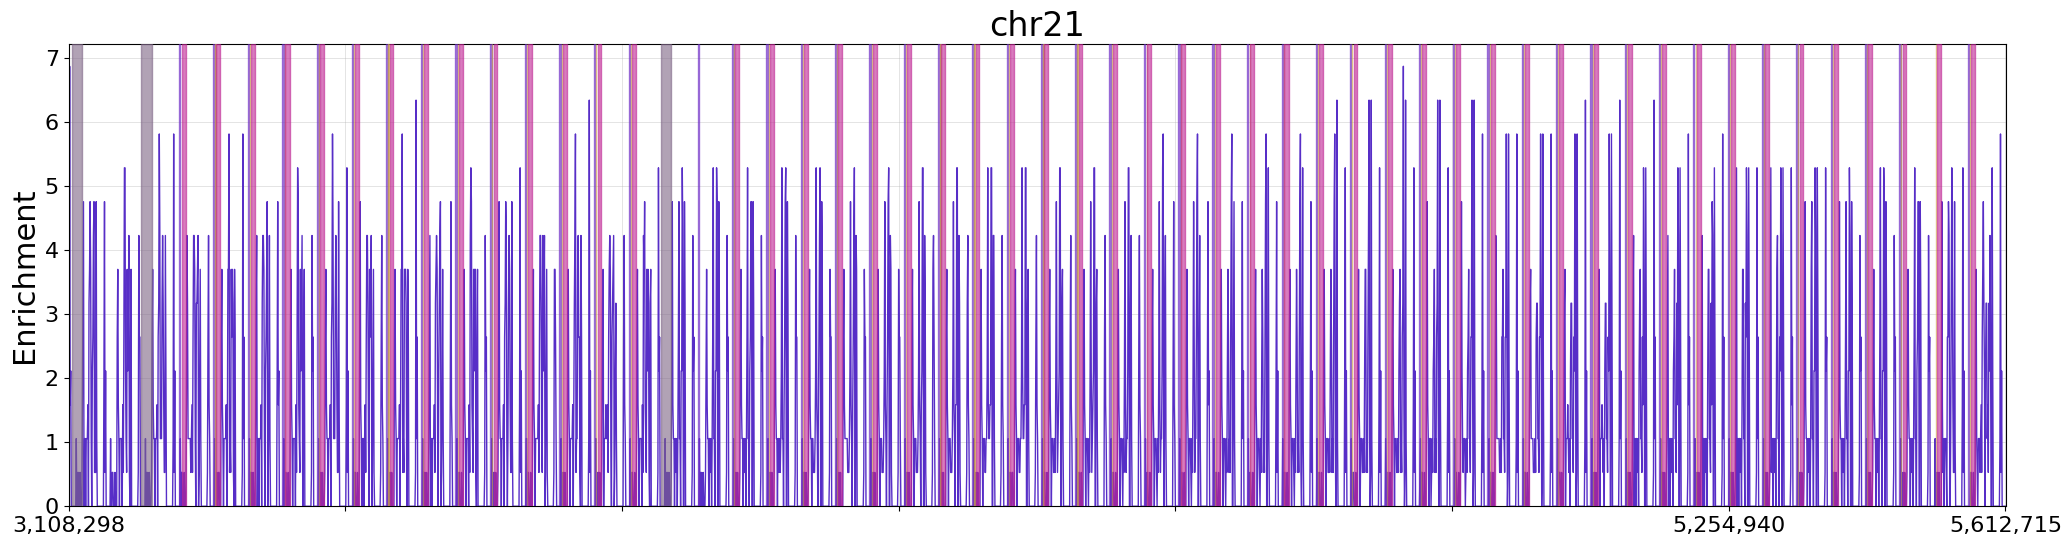

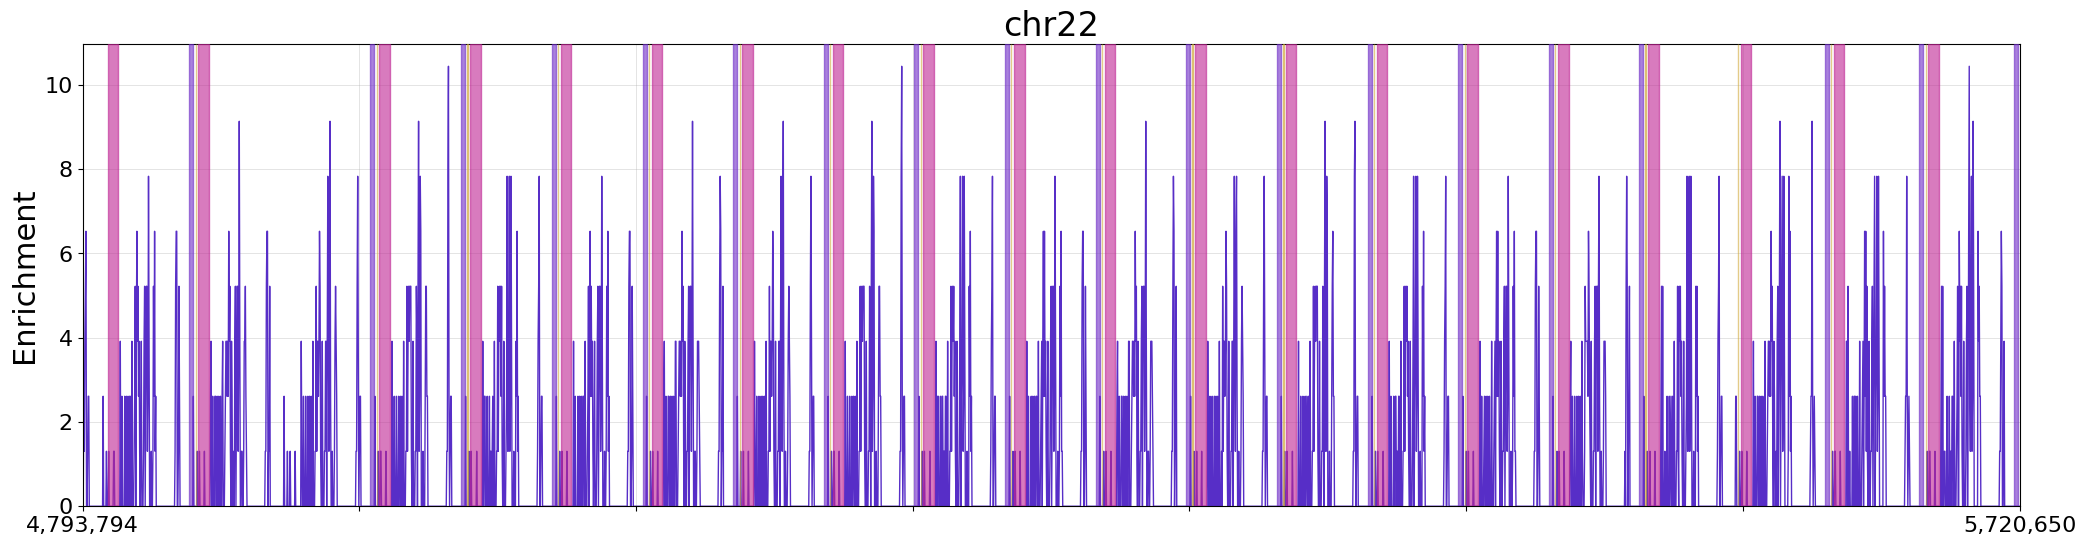

In [44]:
for chromosome in bin_counts:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25, 6),) # height_ratios=[1.7, 2, 2])
    t = pd.DataFrame(bin_counts[chromosome]).T
    u = t.sum(axis=0) #/average
    average = u.mean()
    u = u /average

    t = 100 * (t/t.sum(axis=0))
    t.columns = [str(i) for i in t]
    t = t.T
    
    ax.tick_params(axis="y", which="major", labelsize=16)
    ax.plot(range(1, total_bins+1), u.values, lw=1.0, alpha=1.0, color='#572ec7')
    
    t = merged_gff_norm[merged_gff_norm['chromosome'] == chromosome]
    
    for _, row in t.iterrows():
        rDNA_start = int(row['start_bin'])
        rDNA_end = int(row['end_bin'])
        rRNA_class = row['rRNA_class']
        
        match rRNA_class:
            case 'large':
                color = '#bf2493'
            case 'medium':
                color = '#702ec7'
            case 'small':
                color = '#d1a93b'
            case 'gigantic':
                color = '#7d6585'
   
            
        ax.axvspan(rDNA_start, rDNA_end, color=color, alpha=0.6, zorder=4)

    ax.grid(lw=0.4, alpha=0.6, zorder=0)
    ax.set_ylabel("Enrichment")
    bins = umapping[chromosome]
    labels =  [str(bins.get(i, "")) for i in ax.get_xticks()]
    labels = [l[0] + "," + l[1:4] + "," + l[4:] if len(l) > 0 else l for l in labels]
    ax.set_xticks(ax.get_xticks(), labels)
    
    ax.tick_params(
                   axis="both", 
                   which="major", 
                   labelsize=16
                  )

    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0, xmax=total_bins+1)
    ax.yaxis.label.set_size(22)
    ax.set_title(chromosome)
    ax.title.set_size(24)

    # t.plot.area(color=color_palette, ax=ax[2])
    
    # ax[2].set_ylabel("Spacer Length")
    # ax[1].set_xlim(xmin=0, xmax=2000)
    # ax[2].set_xlim(xmin=-5, xmax=2005)
    # ax[2].set_xticks(range(0, 2200, 200))
    # ax[2].xaxis.set_ticklabels(range(0, 2200, 200))
    # ax.
    
    # for i in range(1, 3):
    #    ax[i].tick_params(axis="y", which="major", labelsize=18)
    #    ax[i].yaxis.label.set_size(20)
    #    ax[i].tick_params(axis="y", which='major', labelsize=18)

    # ax[2].legend(handles=[], frameon=False)
    # ax[2].tick_params(axis="x", which='major', labelsize=18)
    # ax[2].set_ylim(0.0, 100.0)
    # plt.tight_layout()
    # plt.subplots_adjust(hspace=0.1)
    save_att = save_at.joinpath("images_densities")
    save_att.mkdir(exist_ok=True)
    fig.savefig(f"{save_att}/hdna_homo_sapiens_{chromosome}_rDNA_density.png", bbox_inches="tight")
    fig.savefig(f"{save_att}/hdna_homo_sapiens_{chromosome}_rDNA_density.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()

# Coverage Intergenic rDNA

In [53]:
from bed_collection import GFFMindi

t = GFFMindi.parse(gff_paths['chm13v2'])\
            .filter('gene')\
            .to_zero_base()\
            .attributes_to_biotype()\
            .to_dataframe()\
            .query("seq_id != 'chr1' & attributes == 'rRNA'")
t

Processing file /storage/group/izg5139/default/external/satellites/primates/gff/GCF_009914755.1_T2T-CHM13v2.0_genomic.gff.gz with NC_060925.1.


,seq_id,source,compartment,start,end,score,strand,phase,attributes
25800,chr13,cmsearch,gene,5777957,5779826,.,+,.,rRNA
25801,chr13,cmsearch,gene,5780909,5781062,.,+,.,rRNA
25802,chr13,cmsearch,gene,5782235,5787318,.,+,.,rRNA
25803,chr13,cmsearch,gene,5871897,5873766,.,+,.,rRNA
25804,chr13,cmsearch,gene,5874849,5875002,.,+,.,rRNA
...,...,...,...,...,...,...,...,...,...
38306,chr22,cmsearch,gene,5672658,5674527,.,+,.,rRNA
38307,chr22,cmsearch,gene,5675595,5675748,.,+,.,rRNA
38308,chr22,cmsearch,gene,5676921,5681977,.,+,.,rRNA
38310,chr22,cmsearch,gene,5717996,5719865,.,+,.,rRNA


In [46]:
mirror_bed = BedTool.from_dataframe(
                         mirror_df[["chromosome", 
                                   "start", 
                                   "end", 
                                   "spacerLength"
                                  ]].query("chromosome != 'chr1'"),
                        header=None,
                        )
mirror_bed.head()

chr2	29968	29990	2
 chr2	102851	102879	0
 chr2	102854	102880	0
 chr2	119321	119356	1
 chr2	119323	119360	1
 chr2	153244	153271	7
 chr2	153248	153280	6
 chr2	153262	153287	3
 chr2	153315	153336	1
 chr2	153355	153378	1
 

In [47]:
rDNA_bed = BedTool.from_dataframe(rDNA, header=None)
rDNA_bed

<BedTool(/storage/home/nmc6088/scratch/pybedtools.yumch73q.tmp)>

In [66]:
coverage = rDNA_bed.coverage(mirror_bed).to_dataframe()\
                                .rename(columns={"name": "hits", 
                                                "score": "bpCovering",
                                                "strand": "compartmentLength",
                                                "thickStart": "coverage"
                                                }
                                       )
coverage

,chrom,start,end,hits,bpCovering,compartmentLength,coverage
0,chr13,5770548,9348041,10987,251086,3577493,0.070185
1,chr14,2099537,2817811,1814,41620,718274,0.057945
2,chr15,2506442,4707485,5541,129912,2201043,0.059023
3,chr21,3108298,5612715,6363,151642,2504417,0.060550
4,chr22,4793794,5720650,2411,53714,926856,0.057953


In [83]:
coverage_2 = pd.read_table(
                    BedTool.from_dataframe(t).coverage(mirror_bed).fn,
                    header=None,
                    names=["chrom", "source", "compartment", "start", "end", "score", "strand", "phase", "hits", "bpCovering", "compartmentLength", "coverage"],
                )

coverage_2

AttributeError: 'CompletedProcess' object has no attribute 'to_csv'

In [ ]:
total_genic_hits = coverage_2['hits'].sum()
total_intergenic_hits = coverage['hits'].sum()
total_genic_hits, total_intergenic_hits

In [ ]:
total_genic_hits = coverage_2['bpCovering'].sum()
total_intergenic_hits = coverage['bpCovering'].sum()
total_genic_hits, total_intergenic_hits

In [ ]:
total_genic_hits = df_cov_2[4].sum()
total_intergenic_hits = df_cov_1[4].sum()
total_genic_hits, total_intergenic_hits

In [ ]:
df_cov_merged = pd.concat([
                           coverage.assign(compartment="Genic+Intergenic"),
                           coverage_2.assign(compartment="Genic")
                    ], 
                          axis=0)
df_cov_merged.loc[:, "log_coverage"] = df_cov_merged["coverage"].apply(lambda y: math.log(y * 1e6 +1, 10))
df_cov_merged

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.barplot(data=df_cov_merged, 
            x="chrom", 
            y="coverage", 
            hue="compartment", 
            palette=["navy", "magenta"], 
            capsize=.2
           )
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("")
ax.set_ylabel("H-DNA Density")
ax.tick_params(axis="x", which="major", labelsize=16, rotation=45)
ax.tick_params(axis="y", which="major", labelsize=14)
# ax.legend(handles=[], frameon=False)
ax.set_axisbelow(True)
ax.yaxis.label.set_size(18)

/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


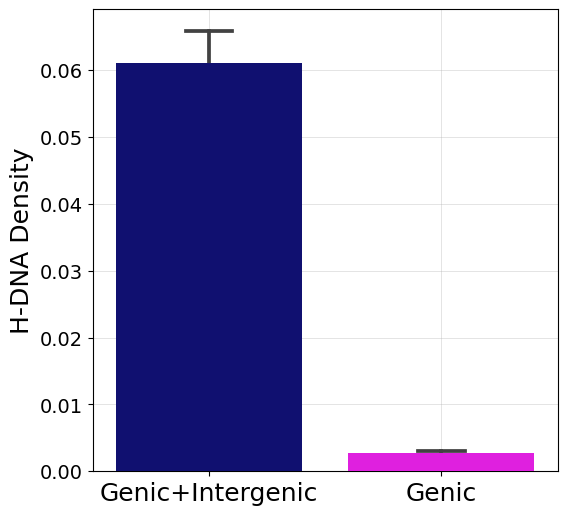

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.barplot(data=df_cov_merged, x="compartment", y="coverage", zorder=4, palette=["navy", "magenta"], capsize=.2)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_xlabel("")
ax.set_ylabel("H-DNA Density")
ax.tick_params(axis="x", 
               which="major", 
               labelsize=18)
ax.tick_params(axis="y", 
               which="major", 
               labelsize=14)
ax.set_axisbelow(True)
ax.yaxis.label.set_size(18)
fig.savefig(f'{save_at}/density_genic_intergenic.png', bbox_inches='tight')

In [74]:
9568, 656419

(9568, 656419)

In [75]:
from bed_collection import GFFMindi

human_gff = GFFMindi.parse(gff_paths['chm13v2'])\
            .filter('gene')\
            .to_zero_base()\
            .attributes_to_biotype()\
            .to_dataframe()
human_gff

Processing file /storage/group/izg5139/default/external/satellites/primates/gff/GCF_009914755.1_T2T-CHM13v2.0_genomic.gff.gz with NC_060925.1.


,seq_id,source,compartment,start,end,score,strand,phase,attributes
0,chr1,BestRefSeq,gene,7505,138480,.,-,.,lncRNA
1,chr1,Gnomon,gene,20891,23710,.,-,.,lncRNA
2,chr1,BestRefSeq,gene,52978,54612,.,-,.,lncRNA
3,chr1,BestRefSeq,gene,111939,112877,.,-,.,protein_coding
4,chr1,BestRefSeq,gene,152268,205171,.,-,.,lncRNA
...,...,...,...,...,...,...,...,...,...
41504,chrY,BestRefSeq,gene,62159111,62204700,.,+,.,protein_coding
41505,chrY,BestRefSeq%2CGnomon,gene,62306324,62368760,.,+,.,protein_coding
41506,chrY,BestRefSeq%2CGnomon,gene,62422542,62435805,.,+,.,protein_coding
41507,chrY,BestRefSeq,gene,62439552,62441822,.,-,.,lncRNA


In [76]:
from tqdm import tqdm
intersections = []

for b in tqdm(["lncRNA", "snRNA", "rRNA", "ncRNA", "snoRNA", "miRNA", "tRNA", "protein_coding",]):
    with tempfile.NamedTemporaryFile(dir=save_at) as mirror_human, \
        tempfile.NamedTemporaryFile(dir=save_at) as genic_human, \
        tempfile.NamedTemporaryFile(dir=save_at) as intersection_human, \
        tempfile.NamedTemporaryFile(dir=save_at) as merged_gff:

        mirror_df[["chromosome", "start", "end", "spacerLength"]].to_csv(mirror_human, sep="\t", index=False, header=None)
        temp = human_gff[human_gff['attributes'] == b][["seq_id", "start", "end", "attributes"]]
        
        temp.to_csv(genic_human, sep="\t", index=False, header=None, mode="w")
        command = f"bedtools merge -i {genic_human.name} -c 4 -o count > {merged_gff.name}"
        t = subprocess.run(command, shell=True, check=True)
        # print(t.stderr, t.stdout.decode("UTF-8"))
        
        # merged_df = pd.read_table(merged_gff, header=None, names=["seq_id", "start", "end", "counts"])
        # merged_df.to_csv()
          
        command = f"bedtools coverage -a {merged_gff.name} -b {mirror_human.name} -wao > {intersection_human.name}"    
        subprocess.run(command, shell=True, check=True)
        
        intersection_df = pd.read_table(intersection_human, 
                                        header=None, 
                                        names=["seq_id", "start", "end", "counts", "hits", "bpOverlap", "compartmentLength", "coverage"],
                                        # names=["seq_id", "start", "end", "biotype", "chromosome", "motif_start", "motif_end", "overlap"]
                                       )
        intersection_df.loc[:, "biotype"] = b
        intersections.append(intersection_df)
            
        
intersections = pd.concat(intersections, axis=0)
intersections

100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


,seq_id,start,end,counts,hits,bpOverlap,compartmentLength,coverage,biotype
0,chr1,7505,138480,3,6,157,130975,0.001199,lncRNA
1,chr1,152268,205171,1,4,72,52903,0.001361,lncRNA
2,chr1,205334,238971,1,1,25,33637,0.000743,lncRNA
3,chr1,246377,248841,1,0,0,2464,0.000000,lncRNA
4,chr1,255177,256494,1,0,0,1317,0.000000,lncRNA
...,...,...,...,...,...,...,...,...,...
17403,chrY,36480751,36497801,1,0,0,17050,0.000000,protein_coding
17404,chrY,62159111,62204700,1,4,143,45589,0.003137,protein_coding
17405,chrY,62306324,62368760,1,0,0,62436,0.000000,protein_coding
17406,chrY,62422542,62435805,1,0,0,13263,0.000000,protein_coding


/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/storage/group/izg5139/default/nicole/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


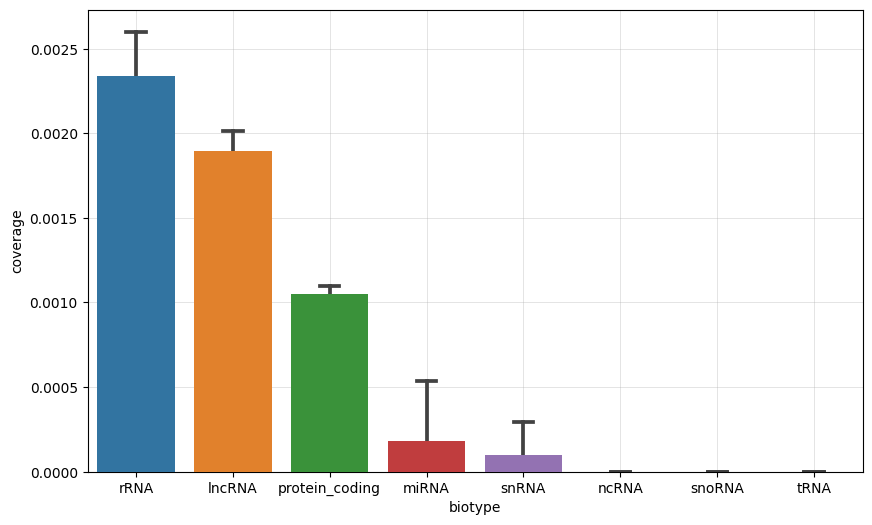

In [77]:
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
sns.barplot(data=intersections, 
            x="biotype", 
            y="coverage", 
            ax=ax, 
            capsize=.2, 
            zorder=3, 
            order=intersections.groupby("biotype")\
                               .agg({"coverage": "mean"})\
                               .sort_values(by=['coverage'], ascending=False).index
           )
ax.grid(lw=0.4, alpha=0.6, zorder=0)

In [78]:
merged_gff = BedTool.from_dataframe(human_gff[(human_gff['attributes'] == 'rRNA') & (human_gff['seq_id'] != 'chr1')])\
                    .sort()\
                    .merge(c=["3", "7"], 
                           s=True, 
                           o=["count", "distinct"]
                          )\
                    .to_dataframe(names=["chromosome", "start", "end", "counts", "strand", "length"])

merged_gff.loc[:, "length"] = merged_gff["end"] - merged_gff["start"]
merged_gff

,chromosome,start,end,counts,strand,length
0,chr13,5777956,5779826,1,+,1870.0
1,chr13,5780908,5781062,1,+,154.0
2,chr13,5782234,5787318,1,+,5084.0
3,chr13,5871896,5873766,1,+,1870.0
4,chr13,5874848,5875002,1,+,154.0
...,...,...,...,...,...,...
632,chr22,5672657,5674527,1,+,1870.0
633,chr22,5675594,5675748,1,+,154.0
634,chr22,5676920,5681977,1,+,5057.0
635,chr22,5717995,5719865,1,+,1870.0


In [79]:
rRNA_classes = {
                '15': 'small',
                '18': 'medium',
                '50': 'large',
                '13': 'gigantic',
            }
merged_gff.loc[:, 'rRNA_class'] = merged_gff['length'].apply(lambda y: rRNA_classes[str(y)[:2]])

In [80]:
merged_gff = merged_gff.merge(rDNA, left_on="chromosome", right_on="chromosome", how="left")
merged_gff

,chromosome,start,end,counts,strand,length,rRNA_class,rDNA_start,rDNA_end
0,chr13,5777956,5779826,1,+,1870.0,medium,5770548,9348041
1,chr13,5780908,5781062,1,+,154.0,small,5770548,9348041
2,chr13,5782234,5787318,1,+,5084.0,large,5770548,9348041
3,chr13,5871896,5873766,1,+,1870.0,medium,5770548,9348041
4,chr13,5874848,5875002,1,+,154.0,small,5770548,9348041
...,...,...,...,...,...,...,...,...,...
632,chr22,5672657,5674527,1,+,1870.0,medium,4793794,5720650
633,chr22,5675594,5675748,1,+,154.0,small,4793794,5720650
634,chr22,5676920,5681977,1,+,5057.0,large,4793794,5720650
635,chr22,5717995,5719865,1,+,1870.0,medium,4793794,5720650


In [81]:
merged_gff = merged_gff.query("rDNA_start <= start & end <= rDNA_end")
merged_gff = merged_gff.query("rRNA_class == 'large' | rRNA_class == 'medium'").reset_index(drop=True)
merged_gff

,chromosome,start,end,counts,strand,length,rRNA_class,rDNA_start,rDNA_end
0,chr13,5777956,5779826,1,+,1870.0,medium,5770548,9348041
1,chr13,5782234,5787318,1,+,5084.0,large,5770548,9348041
2,chr13,5871896,5873766,1,+,1870.0,medium,5770548,9348041
3,chr13,5876174,5881258,1,+,5084.0,large,5770548,9348041
4,chr13,5918866,5920736,1,+,1870.0,medium,5770548,9348041
...,...,...,...,...,...,...,...,...,...
415,chr22,5627357,5629227,1,+,1870.0,medium,4793794,5720650
416,chr22,5631619,5636656,1,+,5037.0,large,4793794,5720650
417,chr22,5672657,5674527,1,+,1870.0,medium,4793794,5720650
418,chr22,5676920,5681977,1,+,5057.0,large,4793794,5720650


In [82]:
merged_gff_next = merged_gff[["start", "end", "length", "rRNA_class", "strand"]].iloc[1:, :].reset_index(drop=True)
merged_gff_duo = merged_gff.merge(merged_gff_next, left_index=True, right_index=True, suffixes=("", "_next")).query("rRNA_class == 'medium' & rRNA_class_next == 'large'")
merged_gff_duo.loc[:, "gap"] = merged_gff_duo["end_next"] - merged_gff_duo["start"]
merged_gff_duo = merged_gff_duo[["chromosome", "start", "end_next", "length", "gap", "rDNA_start", "rDNA_end", "rRNA_class", "rRNA_class_next", "strand", "strand_next"]].rename(columns={"end_next": "end"})
merged_gff_duo.loc[:, "newLength"] = merged_gff_duo["end"] - merged_gff_duo["start"]
merged_gff_duo

,chromosome,start,end,length,gap,rDNA_start,rDNA_end,rRNA_class,rRNA_class_next,strand,strand_next,newLength
0,chr13,5777956,5787318,1870.0,9362,5770548,9348041,medium,large,+,+,9362
2,chr13,5871896,5881258,1870.0,9362,5770548,9348041,medium,large,+,+,9362
4,chr13,5918866,5928228,1870.0,9362,5770548,9348041,medium,large,+,+,9362
6,chr13,5965836,5975198,1870.0,9362,5770548,9348041,medium,large,+,+,9362
8,chr13,6012806,6022168,1870.0,9362,5770548,9348041,medium,large,+,+,9362
...,...,...,...,...,...,...,...,...,...,...,...,...
408,chr22,5451929,5461271,1870.0,9342,4793794,5720650,medium,large,+,+,9342
410,chr22,5495305,5504647,1870.0,9342,4793794,5720650,medium,large,+,+,9342
412,chr22,5538659,5548001,1870.0,9342,4793794,5720650,medium,large,+,+,9342
415,chr22,5627357,5636656,1870.0,9299,4793794,5720650,medium,large,+,+,9299


In [84]:
merged_gff_duo['strand'].unique(), merged_gff_duo['strand_next'].unique()

(array(['+'], dtype=object), array(['+'], dtype=object))

In [ ]:
new_entries = []
entry = None
cur_seq = None


for _, row in merged_gff.iterrows():
    
    start = row['start']
    end = row['end']
    class_ = row['rRNA_class']
    seq_id = row['chrom']

    if cur_seq != seq_id:
        entry = None
        cur_seq = seq_id


    if class_ == 'medium' and entry is None:
        entry = {
                 "start": start, 
                 "seq_id": seq_id, 
                 "end": end,
                 "stacked": "medium",
             }
    elif class_ == 'large' and entry:
        entry.update({"end": end})
        entry["stacked"] += ';large'
        new_entries.append(entry)
        entry = None
        
    elif class_ == "small" and entry:
        entry["stacked"] += ";small"
        continue
    elif class_ == "small" and entry is None:
              entry = {
                 "start": start, 
                 "seq_id": seq_id, 
                 "end": end,
                 "stacked": "small"}
    elif entry is None:
        entry = {"start": start, "end": end, "seq_id": seq_id, "stacked": class_}
        new_entries.append(entry)
        entry = None
    elif class_ == "medium":
        new_entries.append(entry)
        entry = None
        new_entries.append({"start": start, "end": end, "seq_id": seq_id, "stacked": class_})
    else:
        print(entry)
        raise ValueError(f'{row}')
    

new_entries = pd.DataFrame(new_entries)
new_entries

In [85]:
mirror_df_rdna = mirror_df.merge(rDNA, how="left")
mirror_df_rdna.loc[:, "is_rdna"] = (mirror_df_rdna["start"] >= mirror_df_rdna["rDNA_start"]) & (mirror_df_rdna["end"] <= mirror_df_rdna["rDNA_end"])
mirror_df_rdna

,chromosome,sequenceLength,armLength,composition,start,end,sequenceOfArm,sequenceOfSpacer,spacerLength,sequence,arm_a,arm_c,arm_g,arm_t,pyrine,pyrimidine,at_content,rDNA_start,rDNA_end,is_rdna
0,chr1,29,11,3A/0C/8G/0T,50042,50071,ggagggaggga,ggcagaa,7,ggagggagggaggcagaaagggagggagg,3,0,8,0,0.965517,0.034483,0.310345,NaN,NaN,False
1,chr1,27,10,4A/0C/6G/0T,50059,50086,aagggaggga,ggcagaa,7,aagggagggaggcagaaagggagggaa,4,0,6,0,0.962963,0.037037,0.407407,NaN,NaN,False
2,chr1,39,19,15A/0C/4G/0T,73390,73429,agaaagaaaaagaaagaaa,g,1,agaaagaaaaagaaagaaagaaagaaagaaaaagaaaga,15,0,4,0,1.000000,0.000000,0.769231,NaN,NaN,False
3,chr1,43,21,16A/0C/5G/0T,73420,73463,aaagaaagaaagaaagaaaga,a,1,aaagaaagaaagaaagaaagaaagaaagaaagaaagaaagaaa,16,0,5,0,1.000000,0.000000,0.767442,NaN,NaN,False
4,chr1,43,21,16A/0C/5G/0T,73422,73465,agaaagaaagaaagaaagaaa,g,1,agaaagaaagaaagaaagaaagaaagaaagaaagaaagaaaga,16,0,5,0,1.000000,0.000000,0.744186,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205187,chrY,27,13,0A/6C/0G/7T,62192836,62192863,tctctctctctct,c,1,tctctctctctctctctctctctctct,0,6,0,7,0.000000,1.000000,0.518519,NaN,NaN,False
205188,chrY,27,13,0A/7C/0G/6T,62192837,62192864,ctctctctctctc,t,1,ctctctctctctctctctctctctctc,0,7,0,6,0.000000,1.000000,0.481481,NaN,NaN,False
205189,chrY,22,11,7A/0C/4G/0T,62247108,62247130,aaagaaggaag,NaN,0,aaagaaggaaggaaggaagaaa,7,0,4,0,1.000000,0.000000,0.636364,NaN,NaN,False
205190,chrY,28,14,5A/0C/9G/0T,62255805,62255833,aggaggaggaggag,NaN,0,aggaggaggaggaggaggaggaggagga,5,0,9,0,1.000000,0.000000,0.357143,NaN,NaN,False


In [86]:
mirror_df_rdna.is_rdna.value_counts(normalize=True)

is_rdna
False    0.867851
True     0.132149
Name: proportion, dtype: float64

In [87]:
top_consensus = mirror_df_rdna[mirror_df_rdna['is_rdna'] == True].groupby("sequence", as_index=False)\
                    .agg(totalCounts=("start", "count"), 
                         avgSpacer=("spacerLength", "mean"))

sequences = set(top_consensus['sequence'])

def reverse(x):
    return ''.join({
                    'a': 't', 
                    'g': 'c', 
                    'c': 'g', 
                    't': 'a'
                   }.get(n, '-') for n in x)[::-1]

merged_sequences = {}

for _, row in top_consensus.iterrows():
    seq = row['sequence']
    spacer = row['avgSpacer']
    counts = row['totalCounts']
    
    complement = reverse(seq)

    if complement in merged_sequences:
        merged_sequences[complement]['counts'] += counts
        merged_sequences[complement]['spacer'].add(spacer)
    elif seq not in merged_sequences:
        merged_sequences.update({seq: {'counts': counts, 'spacer': {spacer}}})
    else:
        raise ValueError()


merged_sequences_rdna = pd.DataFrame(merged_sequences).T.sort_values(by=['counts'], ascending=False)
total_counts = merged_sequences_rdna['counts'].sum()
print(total_counts, len(merged_sequences_rdna.index))
merged_sequences_rdna.loc[:, "percentage"] = 1e2 * merged_sequences_rdna["counts"].div(total_counts)
merged_sequences_rdna.head(20)

27116 293


,counts,spacer,percentage
ctctctctgtctgtctctctc,1044,{1.0},3.850125
tctctctgtctctgtctctct,695,{1.0},2.563062
agagagagagagagagagaga,671,{1.0},2.474554
agagagagagagagagagagagaga,522,{1.0},1.925063
tgtctctctctctctctctctgt,511,{1.0},1.884496
agagagagagagagagagagagagaga,502,{1.0},1.851306
ctctctctctctctctctctctctctc,500,{1.0},1.84393
ctctctctctctctctctctc,489,{1.0},1.803363
agagagagagagagagagagaga,450,{1.0},1.659537
gaaaagaaagagaaaatgaaagaaaag,440,{7.0},1.622658


<Axes: ylabel='Frequency'>

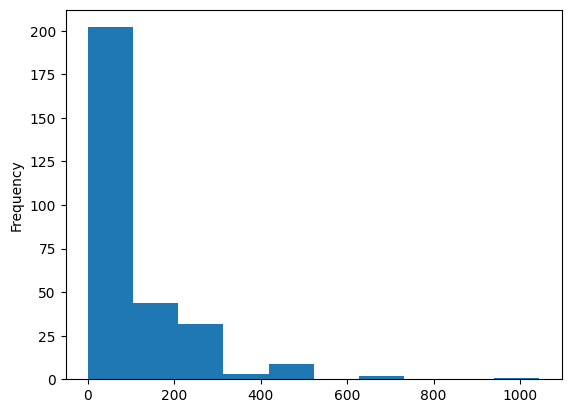

In [89]:
merged_sequences_rdna['counts'].plot(kind="hist")

In [90]:
human_gff[human_gff['attributes'] == 'rRNA'].query("seq_id == 'chr13'").head(40)

,seq_id,source,compartment,start,end,score,strand,phase,attributes
25800,chr13,cmsearch,gene,5777957,5779826,.,+,.,rRNA
25801,chr13,cmsearch,gene,5780909,5781062,.,+,.,rRNA
25802,chr13,cmsearch,gene,5782235,5787318,.,+,.,rRNA
25803,chr13,cmsearch,gene,5871897,5873766,.,+,.,rRNA
25804,chr13,cmsearch,gene,5874849,5875002,.,+,.,rRNA
25805,chr13,cmsearch,gene,5876175,5881258,.,+,.,rRNA
25806,chr13,cmsearch,gene,5918867,5920736,.,+,.,rRNA
25807,chr13,cmsearch,gene,5921819,5921972,.,+,.,rRNA
25808,chr13,cmsearch,gene,5923145,5928228,.,+,.,rRNA
25811,chr13,cmsearch,gene,5965837,5967706,.,+,.,rRNA


In [91]:
top_consensus = mirror_df_rdna.groupby("sequence", as_index=False)\
                    .agg(totalCounts=("start", "count"), 
                         avgSpacer=("spacerLength", "mean"))

sequences = set(top_consensus['sequence'])

def reverse(x):
    return ''.join({'a': 't', 'g': 'c', 'c': 'g', 't': 'a'}.get(n, '-') for n in x)[::-1]

merged_sequences = {}

for _, row in top_consensus.iterrows():
    seq = row['sequence']
    spacer = row['avgSpacer']
    counts = row['totalCounts']
    
    complement = reverse(seq)

    if complement in merged_sequences:
        merged_sequences[complement]['counts'] += counts
        merged_sequences[complement]['spacer'].add(spacer)
    elif seq not in merged_sequences:
        merged_sequences.update({seq: {'counts': counts, 'spacer': {spacer}}})
    else:
        raise ValueError()


merged_sequences = pd.DataFrame(merged_sequences).T.sort_values(by=['counts'], ascending=False)
total_counts = merged_sequences['counts'].sum()
print(total_counts, len(merged_sequences.index))
merged_sequences.loc[:, "percentage"] = 1e2 * merged_sequences["counts"].div(total_counts)
merged_sequences.head(20)

205192 56859


,counts,spacer,percentage
agagagagagagagagagaga,2222,{1.0},1.082888
ctctctctctctctctctctc,1680,{1.0},0.818745
agagagagagagagagagagaga,1587,{1.0},0.773422
agagagagagagagagagagagaga,1427,{1.0},0.695446
agagagagagagagagagagagagaga,1296,{1.0},0.631604
ctctctctctctctctctctctc,1155,{1.0},0.562887
aaagaaagaaagaaagaaagaaa,1135,{1.0},0.55314
ctctctctctctctctctctctctctc,1077,{1.0},0.524874
ctctctctgtctgtctctctc,1068,{1.0},0.520488
agagagagagagagagagagagagagaga,906,{1.0},0.441538


In [92]:
merged_sequences_all = merged_sequences.merge(merged_sequences_rdna, left_index=True, right_index=True, how="left")
merged_sequences_all.loc[:, "enrichment"] = merged_sequences_all["percentage_y"].div(merged_sequences_all["percentage_x"])
merged_sequences_all['enrichment'] = merged_sequences_all['enrichment'].fillna(0)
merged_sequences_all = merged_sequences_all.sort_values(by=['enrichment'], ascending=False)
merged_sequences_all.head(40)

,counts_x,spacer_x,percentage_x,counts_y,spacer_y,percentage_y,enrichment
tttttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttttt,74,{0.0},0.036064,74,{0.0},0.272902,7.567193
tctctctctgtctctctctgtctctctctctctctgtctctctct,74,{7.0},0.036064,74,{7.0},0.272902,7.567193
ctctctctttctgtctgtttctctctc,296,{7.0},0.144255,296,{7.0},1.091606,7.567193
tctctctccctgtccctctctct,296,{1.0},0.144255,296,{1.0},1.091606,7.567193
tctctttctctgtctgtctgtctctttctct,296,{1.0},0.144255,296,{1.0},1.091606,7.567193
tttttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttcttttt,37,{0.0},0.018032,37,{0.0},0.136451,7.567193
tctctctctctctctctgtctgtctctttcgttctctctgtctgtctctctctctctctct,37,{7.0},0.018032,37,{7.0},0.136451,7.567193
ttctttctttctttctttctatctttctttctttctt,1,{5.0},0.000487,1,{5.0},0.003688,7.567193
gagagaggggggaggggggggggggagagag,1,{7.0},0.000487,1,{7.0},0.003688,7.567193
cctccctcccttcctgctcccttccctccctcc,73,{5.0},0.035576,73,{5.0},0.269214,7.567193


# TSS - TES Densities

In [93]:
merged_gff

,chromosome,start,end,counts,strand,length,rRNA_class,rDNA_start,rDNA_end
0,chr13,5777956,5779826,1,+,1870.0,medium,5770548,9348041
1,chr13,5782234,5787318,1,+,5084.0,large,5770548,9348041
2,chr13,5871896,5873766,1,+,1870.0,medium,5770548,9348041
3,chr13,5876174,5881258,1,+,5084.0,large,5770548,9348041
4,chr13,5918866,5920736,1,+,1870.0,medium,5770548,9348041
...,...,...,...,...,...,...,...,...,...
415,chr22,5627357,5629227,1,+,1870.0,medium,4793794,5720650
416,chr22,5631619,5636656,1,+,5037.0,large,4793794,5720650
417,chr22,5672657,5674527,1,+,1870.0,medium,4793794,5720650
418,chr22,5676920,5681977,1,+,5057.0,large,4793794,5720650


In [94]:
mirror_bed.head()

chr2	29968	29990	2
 chr2	102851	102879	0
 chr2	102854	102880	0
 chr2	119321	119356	1
 chr2	119323	119360	1
 chr2	153244	153271	7
 chr2	153248	153280	6
 chr2	153262	153287	3
 chr2	153315	153336	1
 chr2	153355	153378	1
 

In [116]:
merged_gff_bed = merged_gff[["chromosome", "start", "end"]]

window = 3_000
mirror_bed = BedTool.from_dataframe(mirror_df[["chromosome", "start", "end", "sequenceOfArm", "sequence", "sequenceOfSpacer"]])

intersections = {}
for transcriptionSite in ["start", "end"]:

    temp = merged_gff_bed.copy()
    if transcriptionSite == "start":
        temp.loc[:, "end"] = temp[transcriptionSite] + window
        temp.loc[:, "start"] = np.maximum(temp[transcriptionSite] - window, 0)
    else:
        temp.loc[:, "start"] = np.maximum(temp[transcriptionSite] - window, 0)
        temp.loc[:, "end"] = temp[transcriptionSite] + window

    temp_bed = BedTool.from_dataframe(temp)
    intersect_df = temp_bed.intersect(mirror_bed, wo=True)
    intersections.update({transcriptionSite: pd.read_table(intersect_df.fn, 
                                                           header=None, 
                                                           names=["chromosome", 
                                                                  "start", 
                                                                  "end", 
                                                                  "seq_id", 
                                                                  "motifStart", 
                                                                  "motifEnd", 
                                                                  "sequenceOfArm", 
                                                                  "sequence", 
                                                                  "sequenceOfSpacer", 
                                                                  "overlap"
                                                                 ]
                                                          )
                         })
intersections["start"]

,chromosome,start,end,seq_id,motifStart,motifEnd,sequenceOfArm,sequence,sequenceOfSpacer,overlap
0,chr13,5774956,5780956,chr13,5780016,5780049,gagagagagagagaga,gagagagagagagagagagagagagagagagag,g,33
1,chr13,5774956,5780956,chr13,5780017,5780050,agagagagagagagag,agagagagagagagagagagagagagagagaga,a,33
2,chr13,5779234,5785234,chr13,5780016,5780049,gagagagagagagaga,gagagagagagagagagagagagagagagagag,g,33
3,chr13,5779234,5785234,chr13,5780017,5780050,agagagagagagagag,agagagagagagagagagagagagagagagaga,a,33
4,chr13,5779234,5785234,chr13,5781670,5781694,cctcctccccgc,cctcctccccgccgcccctcctcc,.,24
...,...,...,...,...,...,...,...,...,...,...
1171,chr22,5584008,5590008,chr22,5587571,5587591,gcccctcctc,gcccctcctcctcctccccg,.,20
1172,chr22,5628619,5634619,chr22,5631055,5631079,cctcctccccgc,cctcctccccgccgcccctcctcc,.,24
1173,chr22,5628619,5634619,chr22,5632182,5632202,gcccctcctc,gcccctcctcctcctccccg,.,20
1174,chr22,5673920,5679920,chr22,5676356,5676380,cctcctccccgc,cctcctccccgccgcccctcctcc,.,24


In [117]:
t = intersections["end"] 
# 
t.sequence.value_counts().sort_values(ascending=False) # ctctctctgtctgtctctctc	

sequence
tttctttctttctttctttctttctttctttctttctttctttctttcttt    260
tctttctttctttctttctttctttctttctttctttctttctttctttct    260
gcccctcctcctcctccccg                                   208
cctcctccccgccgcccctcctcc                               192
tctctctctctctctctctctct                                185
                                                      ... 
tttttctttctttctttctttctttctttcttttt                      1
ctctctctctctctctctctctctctctctctctctc                    1
ttccttccttccttccttcctt                                   1
tctctctctctctctctctctctctctctctctctctctct                1
tccttccttccttccttccttcct                                 1
Name: count, Length: 95, dtype: int64

In [104]:
intersections["start"].sequenceOfSpacer.value_counts()

sequenceOfSpacer
.        401
g        380
a        380
cgccg     15
Name: count, dtype: int64

In [111]:
gff_paths

{'chm13v2': PosixPath('/storage/group/izg5139/default/external/satellites/primates/gff/GCF_009914755.1_T2T-CHM13v2.0_genomic.gff.gz'),
 'mPanTro3_v2': PosixPath('/storage/group/izg5139/default/external/satellites/primates/gff/GCF_028858775.2_NHGRI_mPanTro3-v2.0_pri_genomic.gff.gz'),
 'mSymSyn1_v2': PosixPath('/storage/group/izg5139/default/external/satellites/primates/gff/GCF_028878055.2_NHGRI_mSymSyn1-v2.0_pri_genomic.gff.gz'),
 'mPonAbe1_v2': PosixPath('/storage/group/izg5139/default/external/satellites/primates/gff/GCF_028885655.2_NHGRI_mPonAbe1-v2.0_pri_genomic.gff.gz'),
 'mGorGor1_v2': PosixPath('/storage/group/izg5139/default/external/satellites/primates/gff/GCF_029281585.2_NHGRI_mGorGor1-v2.0_pri_genomic.gff.gz'),
 'mPanPan1_v2': PosixPath('/storage/group/izg5139/default/external/satellites/primates/gff/GCF_029289425.2_NHGRI_mPanPan1-v2.0_pri_genomic.gff.gz')}

In [113]:
from pathlib import Path
from bed_collection import GFFMindi
import pandas as pd
import tempfile

save_at = Path(f"/storage/group/izg5139/default/external/satellites/primates/temp")
save_at.mkdir(exist_ok=True)
intersections = []
window = 2_000
human_mint = GFFMindi.parse(gff_paths['chm13v2'])

for transcriptionSite in ["start", "end"]:
    with tempfile.NamedTemporaryFile(dir=save_at) as mirror_human, \
            tempfile.NamedTemporaryFile(dir=save_at) as genic_human, \
            tempfile.NamedTemporaryFile(dir=save_at) as intersection_human:
        
        mirror_df[["chromosome", "start", "end"]].to_csv(mirror_human, sep="\t", index=False, header=None)
                
        human_mint.filter(compartment="gene")\
                  .to_zero_base(transcriptionSite)\
                  .attributes_to_biotype()\
                  .expand(on=transcriptionSite, window=window)\
                  .to_bed(genic_human, usecols=["seq_id", "start", "end", "strand", "attributes"])
                
        command = f"bedtools intersect -a {genic_human.name} -b {mirror_human.name} -wao > {intersection_human.name}"    
        subprocess.run(command, shell=True, check=True)
        intersection_df = pd.read_table(
                                        intersection_human, 
                                        header=None, 
                                        names=["seq_id", "start", "end", "strand", "biotype", "chromosome", "motif_start", "motif_end", "overlap"]
                                       )
        intersection_df.loc[:, "is_overlapping"] = (intersection_df["overlap"] > 0).astype(int)
        intersection_df.loc[:, "site"] = transcriptionSite
        intersections.append(intersection_df)
    

intersections = pd.concat(intersections, axis=0)
intersections

Processing file /storage/group/izg5139/default/external/satellites/primates/gff/GCF_009914755.1_T2T-CHM13v2.0_genomic.gff.gz with NC_060925.1.


,seq_id,start,end,strand,biotype,chromosome,motif_start,motif_end,overlap,is_overlapping,site
0,chr1,5505,9505,-,lncRNA,.,-1,-1,0,0,start
1,chr1,18891,22891,-,lncRNA,.,-1,-1,0,0,start
2,chr1,50978,54978,-,lncRNA,.,-1,-1,0,0,start
3,chr1,109939,113939,-,protein_coding,.,-1,-1,0,0,start
4,chr1,150268,154268,-,lncRNA,.,-1,-1,0,0,start
...,...,...,...,...,...,...,...,...,...,...,...
51628,chrY,62202700,62206700,+,protein_coding,.,-1,-1,0,0,end
51629,chrY,62366760,62370760,+,protein_coding,.,-1,-1,0,0,end
51630,chrY,62433805,62437805,+,protein_coding,.,-1,-1,0,0,end
51631,chrY,62439822,62443822,-,lncRNA,.,-1,-1,0,0,end


In [114]:
from collections import Counter

overlapping_sequences = Counter(intersections.query("site == 'start' & biotype == 'rRNA'")['sequence'])
len(overlapping_sequences)

KeyError: 'sequence'

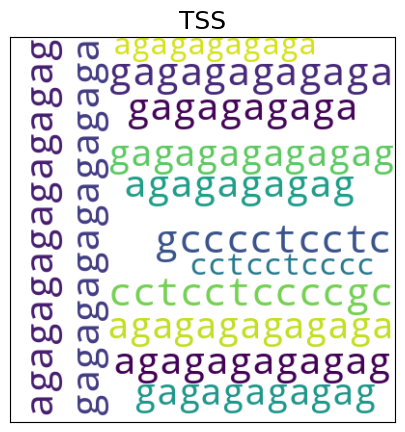

In [118]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

overlapping_sequences = Counter(intersections['start']['sequenceOfArm'])
most_common = set(map(lambda x: x[0], overlapping_sequences.most_common(50)))

# Join the set into a single string
text = ' '.join(seq for seq in overlapping_sequences if seq in most_common)

# Generate the word cloud
wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
 # Remove axes
plt.title("TSS")
plt.gca().title.set_size(18)
plt.gca().set_yticks([])
plt.gca().set_xticks([])
plt.gcf().savefig("TSS_wordcloud_rRNA.png", bbox_inches='tight')
plt.show()

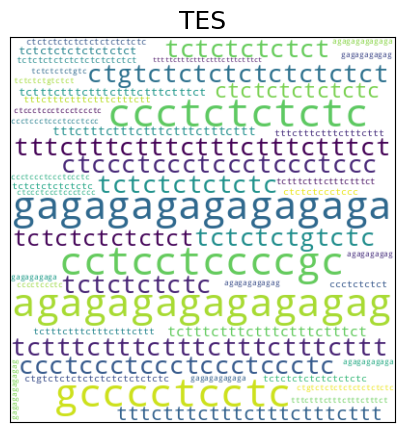

In [119]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


overlapping_sequences = Counter(intersections['end']['sequenceOfArm'])
most_common = set(map(lambda x: x[0], overlapping_sequences.most_common(50)))

# Join the set into a single string
text = ' '.join(seq for seq in overlapping_sequences if seq in most_common)

# Generate the word cloud
wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
 # Remove axes
plt.title("TES")
plt.gca().title.set_size(18)
plt.gca().set_yticks([])
plt.gca().set_xticks([])
plt.gcf().savefig("TSE_wordcloud_rRNA.png", bbox_inches='tight')
plt.show()

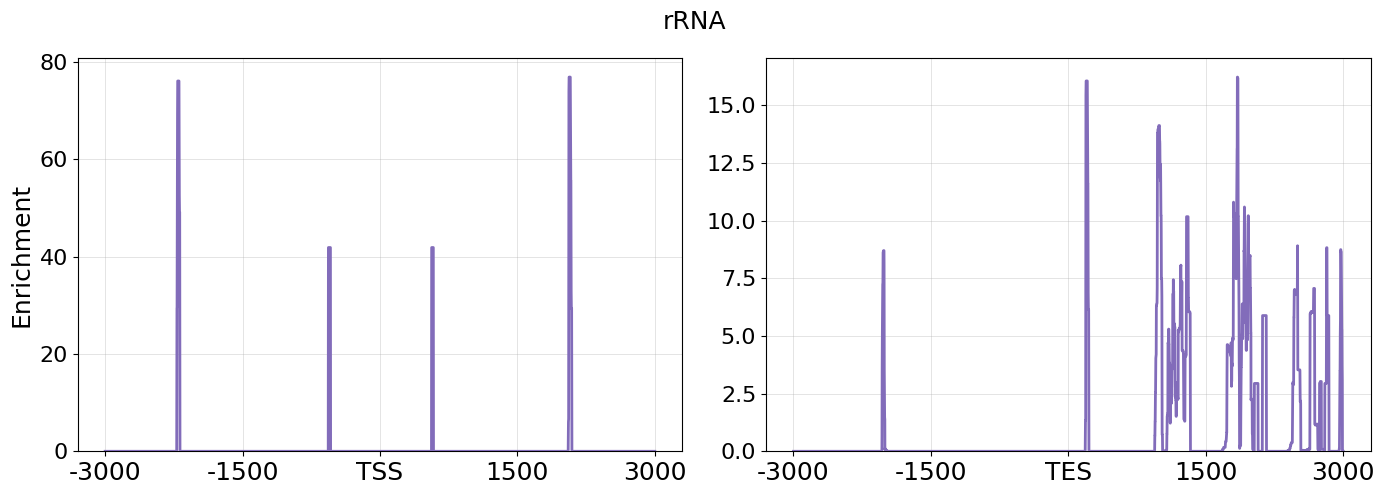

In [120]:
# counts = np.zeros(2001)
window = 3_000

biotypes = {"tRNA", "protein_coding", "rRNA"}
colors = {
          'tRNA': '#648491',
          'rRNA': '#826cba',
          'protein_coding': '#9363b8'
         }

nucleotides = "agct"
maximum_points = {}
for b in ['rRNA']:
    
    # counts = 
    sites = {
             "start": np.zeros(2*window+1),
             "end": np.zeros(2*window+1)
        }
    
    logos = {'start':
             {n: np.zeros(2*window+1) for n in nucleotides},
         'end':
           {n: np.zeros(2*window+1) for n in nucleotides},
        }

    
    for site in ["start", "end"]:
        temp = intersections[site]
        maximum_points[site] = []

        for _, row in temp.iterrows():
            start = int(row['start'])
            end = int(row['end'])
            start_motif = row['motifStart']
            end_motif = row['motifEnd']
            strand = '+' # row['strand']
            sequence = row['sequence']
            overlap = row['overlap']
            
            origin = end - window
            L = max(window - (origin - start_motif), 0)
            U = min(window - (origin - end_motif), 2 * window) 

            inf = max(start_motif, start) - start_motif
            sup = min(end_motif, end) - start_motif
            overlapping_chunk = sequence[inf: sup]

            assert overlap == len(overlapping_chunk) == U - L, f"{start}, {origin}, {end}, {start_motif}, {end_motif}, {U},{L},{U-L},{overlap},{overlapping_chunk},{len(sequence)}, {len(overlapping_chunk)}"
        
            # Χ = 5 ----10-----15 
            # M = 3 7
            #     5 - (10-3) = 5 - 7 = -2 -> 0
            #     5 - (10-7) = 5 - 3 = 2 -> 2
            #     11
                
            # print(overlapping_chunk, inf, sup, end_motif-start_motif)
            
            for idx, i in enumerate(range(L, U), 0):
                if strand == '-':
                    sites[site][window*2-i] += 1
                    logos[site][overlapping_chunk[idx]][window*2-i] += 1
                else:
                    sites[site][i] += 1
                    logos[site][overlapping_chunk[idx]][i] += 1
            
        sites[site]= sites[site] / np.mean(sites[site])

        for loc, i in enumerate(sites[site]):
            if (i > 22 and site=="start") or i > 6:
                maximum_points[site].append((loc, i))
        
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    max_alpha = 1.0
    ax[0].plot(range(2*window+1), sites["start"], lw=2.0, color=colors[b], zorder=3) 
    ax[1].plot(range(2*window+1), sites["end"], lw=2.0, color=colors[b], zorder=3)

    for i in range(2):
        ax[i].grid(lw=0.4, alpha=0.6, zorder=0)
        ax[i].set_xlabel("")
        ax[i].tick_params(which="major", labelsize=16,)
        ax[i].tick_params(axis="x", which="major", labelsize=18)
        # ax[i].set_xticklabels(range(-1500, 1500, 500))
        ax[i].legend(frameon=False, handles=[])
        ax[i].set_ylim(ymin=0)
        ax[i].set_xticks(range(0, window*2+500, window//2), [f'{j-window}' if j != window else ('TSS' if i == 0 else 'TES') for j in range(0, window*2+500, window//2)])

    ax[0].set_ylabel("")
    ax[0].set_ylabel("Enrichment")
    ax[0].yaxis.label.set_size(18)

    title = {
             'protein_coding': 'Protein Coding',
             'tRNA': 'tRNA',
             'rRNA': 'rRNA'
            }
    plt.suptitle(title[b], fontsize=18)
    plt.tight_layout()
    fig.savefig(f"{b}_density_TSS_TSE_hdna.png", bbox_inches='tight')
    
    plt.show()
    plt.close()

In [121]:
logos_pn = {}
for transcriptionSite in ["start", "end"]:
    logos_df = pd.DataFrame(logos[transcriptionSite])
    logos_df.loc[:, "total"] = logos_df.sum(axis=1)
    for n in nucleotides:
        logos_df[n] = logos_df[n].div(logos_df['total'])
    logos_df.drop(columns=['total'], inplace=True)
    print(logos_df)
    logos_pn.update({transcriptionSite: logos_df})

       a   g   c   t
0    NaN NaN NaN NaN
1    NaN NaN NaN NaN
2    NaN NaN NaN NaN
3    NaN NaN NaN NaN
4    NaN NaN NaN NaN
...   ..  ..  ..  ..
5996 NaN NaN NaN NaN
5997 NaN NaN NaN NaN
5998 NaN NaN NaN NaN
5999 NaN NaN NaN NaN
6000 NaN NaN NaN NaN

[6001 rows x 4 columns]
       a   g   c   t
0    NaN NaN NaN NaN
1    NaN NaN NaN NaN
2    NaN NaN NaN NaN
3    NaN NaN NaN NaN
4    NaN NaN NaN NaN
...   ..  ..  ..  ..
5996 NaN NaN NaN NaN
5997 NaN NaN NaN NaN
5998 NaN NaN NaN NaN
5999 NaN NaN NaN NaN
6000 NaN NaN NaN NaN

[6001 rows x 4 columns]


In [123]:
from collections import defaultdict
to_draw_points = defaultdict(list)


for transcriptionSite in ["start", "end"]:
    prev_val = - float('inf')
    for record in maximum_points[transcriptionSite]:
        pos, val = record
    
        if pos == prev_val + 1:
            prev_val = pos
            continue
        else:
            if len(to_draw_points[transcriptionSite]) > 0:
                to_draw_points[transcriptionSite][-1].update({'end': prev_val})
                
            to_draw_points[transcriptionSite].append({'start': pos})
            prev_val = pos
    
    to_draw_points[transcriptionSite][-1].update({'end': prev_val})

In [124]:
logos_pn['end'].loc[3224: 3229]

,a,g,c,t
3224,NaN,NaN,NaN,NaN
3225,NaN,NaN,NaN,NaN
3226,NaN,NaN,NaN,NaN
3227,NaN,NaN,NaN,NaN
3228,NaN,NaN,NaN,NaN
3229,NaN,NaN,NaN,NaN


In [125]:
save_at

PosixPath('/storage/group/izg5139/default/external/satellites/primates/temp')

PRINTING transcriptionSite='start'...
{'start': 782, 'end': 815}


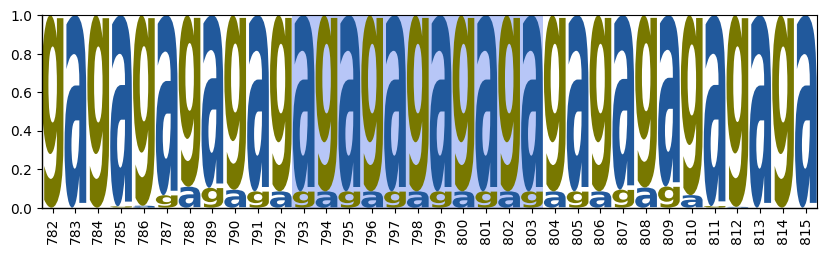

{'start': 2436, 'end': 2459}


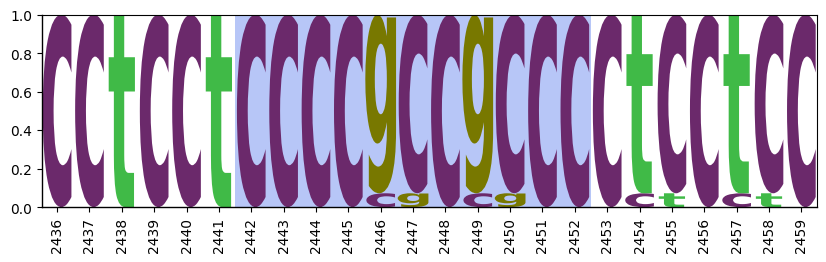

{'start': 3563, 'end': 3582}


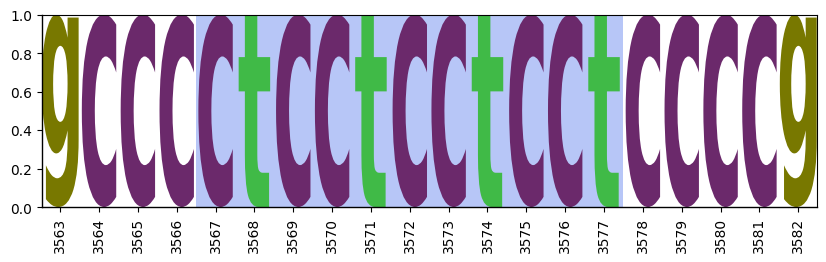

{'start': 5056, 'end': 5093}


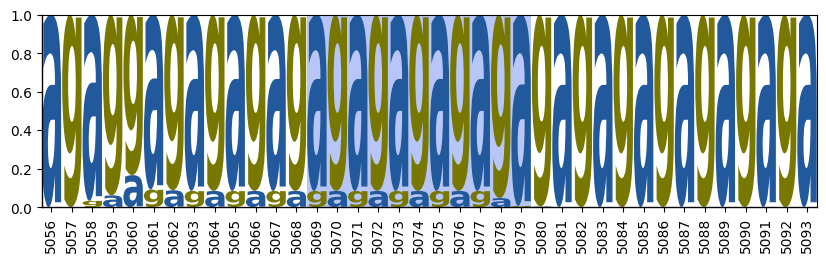

PRINTING transcriptionSite='end'...
{'start': 972, 'end': 989}


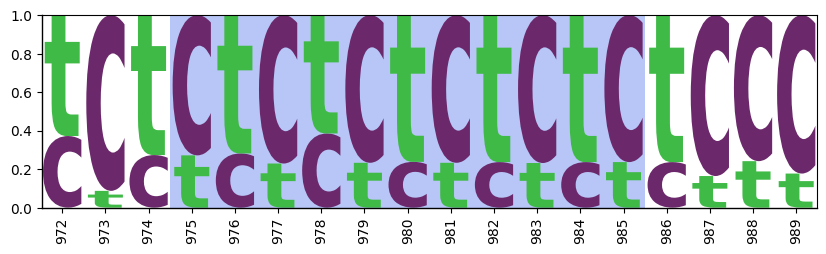

{'start': 3190, 'end': 3222}


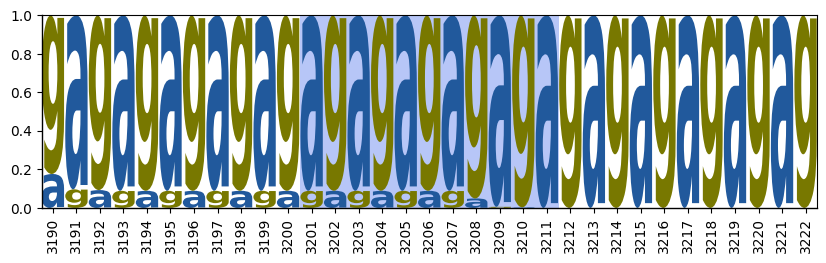

{'start': 3960, 'end': 4021}


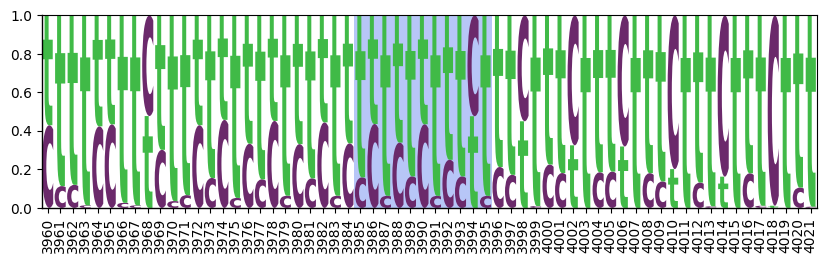

{'start': 4139, 'end': 4150}


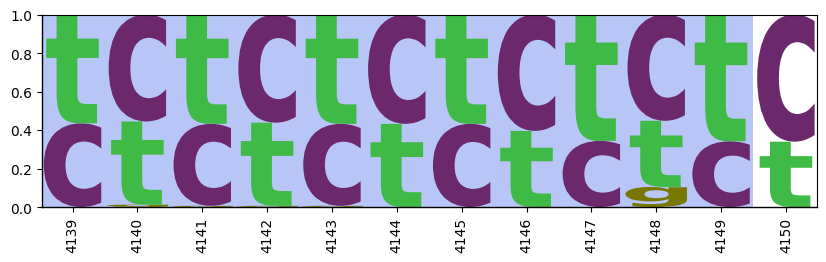

{'start': 4222, 'end': 4240}


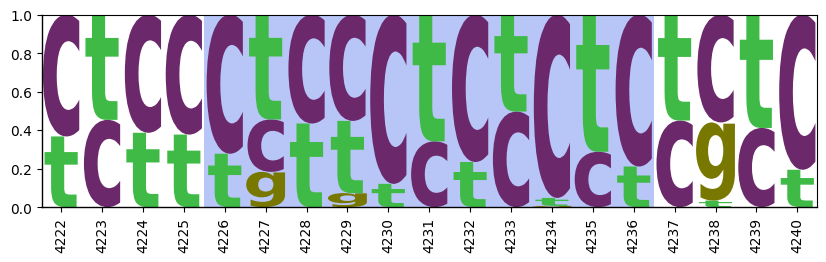

{'start': 4288, 'end': 4328}


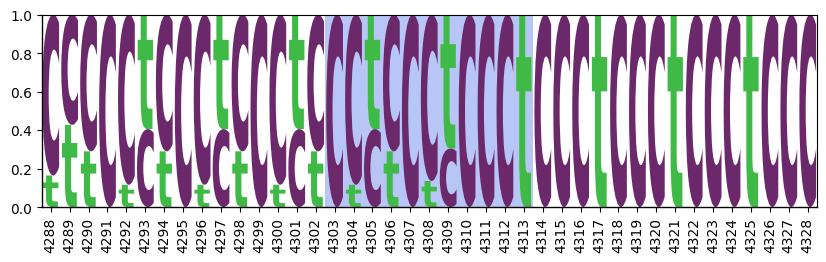

{'start': 4801, 'end': 4863}


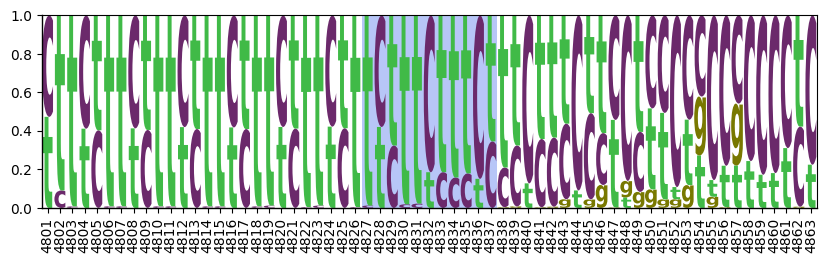

{'start': 4897, 'end': 4902}


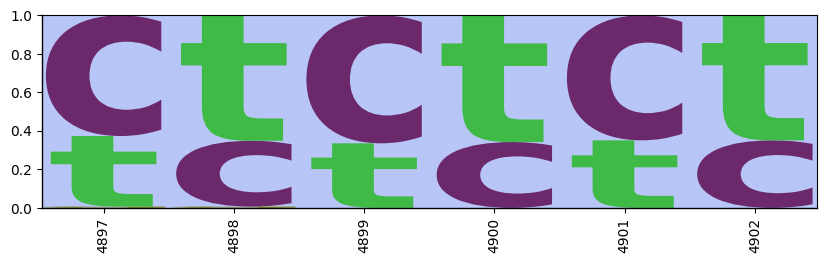

{'start': 4905, 'end': 4906}


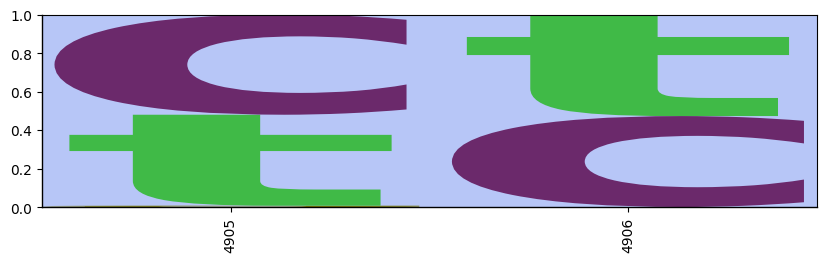

{'start': 4917, 'end': 4935}


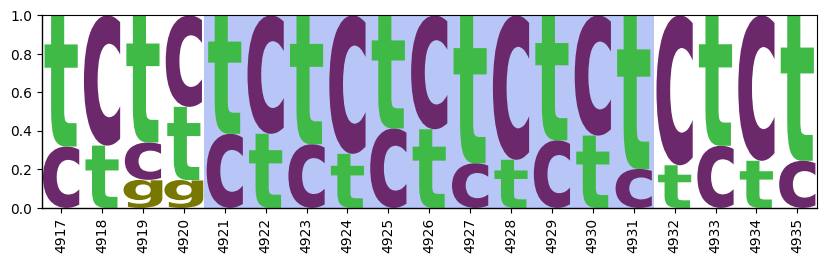

{'start': 4958, 'end': 4989}


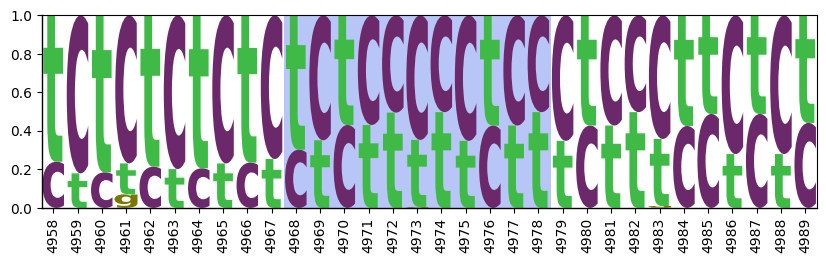

{'start': 5464, 'end': 5503}


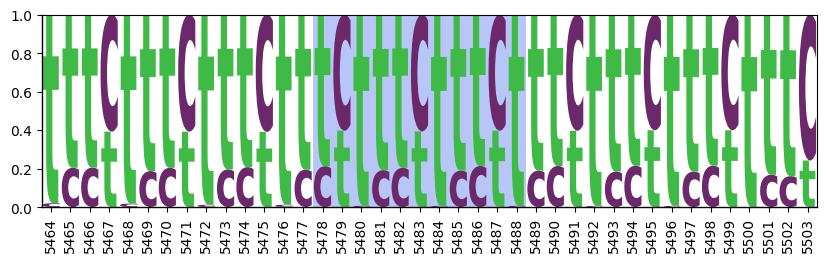

{'start': 5646, 'end': 5687}


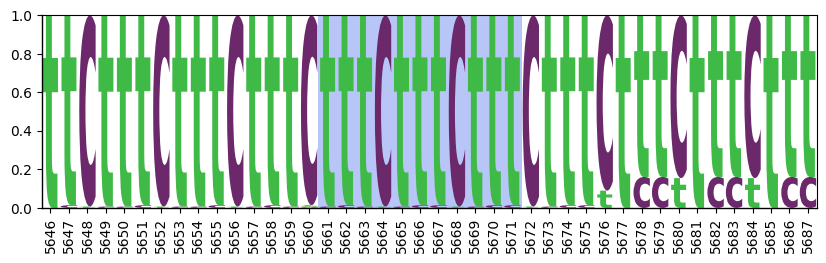

{'start': 5818, 'end': 5823}


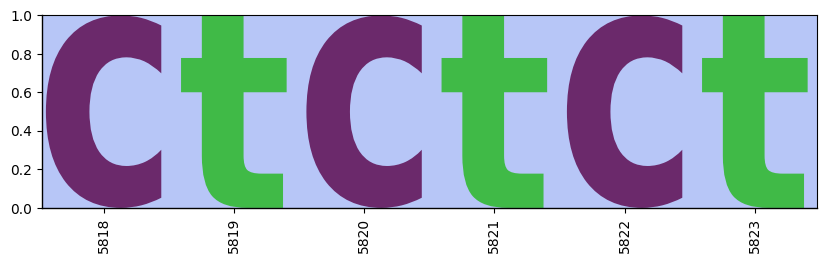

{'start': 5971, 'end': 5982}


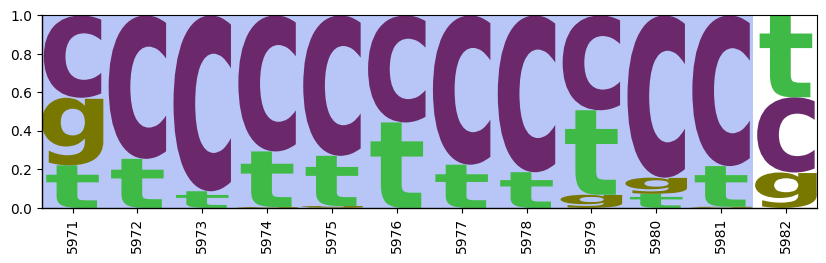

In [127]:
import logomaker

for transcriptionSite in ["start", "end"]:
    print(f"PRINTING {transcriptionSite=}...")
    
    for coords in to_draw_points[transcriptionSite]:

        if coords['start'] == coords['end']:
            continue
        print(coords)            
        crp_logo = logomaker.Logo(logos_pn[transcriptionSite].loc[coords['start']:coords['end']],
                              shade_below=.5,
                              fade_below=.5,
                              # vpad=.05,
                              # fade_probabilities=True,
                             #stack_order='small_on_top',
                             color_scheme='NajafabadiEtAl2017', 
                            #'dodgerblue',
                            # color_scheme='skylign_protein'
                            # width=.7
                        )
    
        # style using Logo methods
        # crp_logo.style_spines(visible=False)
        mid = (coords['start'] + coords['end'])//2
        crp_logo.highlight_position_range(pmin=mid-5, 
                                      pmax=mid+5, 
                                      color='#b7c6f7')
        
        crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
        crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

        Path("/storage/group/izg5139/default/external/satellites/primates/temp/logos").mkdir(exist_ok=True)
        plt.gcf().savefig(f"/storage/group/izg5139/default/external/satellites/primates/temp/logos/{coords['start']}-{coords['end']}_{transcriptionSite}_logomaker.png", bbox_inches='tight')
        plt.show()
        plt.close()

In [128]:
maximum_points['start'][100:140]

[(5078, 73.8974935409187),
 (5079, 70.8771600174479),
 (5080, 70.67580444921653),
 (5081, 63.02429285642385),
 (5082, 55.57413683186257),
 (5083, 55.57413683186257),
 (5084, 55.57413683186257),
 (5085, 45.90906955675603),
 (5086, 36.2440022816495),
 (5087, 32.820957621715934),
 (5088, 29.39791296178237),
 (5089, 29.39791296178237),
 (5090, 29.39791296178237),
 (5091, 29.39791296178237),
 (5092, 29.39791296178237),
 (5093, 14.698956480891185)]

In [129]:
logos_df = pd.DataFrame(logos['start'])
logos_df.loc[:, "total"] = logos_df.sum(axis=1)
for n in nucleotides:
    logos_df[n] = logos_df[n].div(logos_df['total'])
logos_df.drop(columns=['total'], inplace=True)
    
logos_df

,a,g,c,t
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
5996,NaN,NaN,NaN,NaN
5997,NaN,NaN,NaN,NaN
5998,NaN,NaN,NaN,NaN
5999,NaN,NaN,NaN,NaN


In [130]:
logos_df[n]

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
5996   NaN
5997   NaN
5998   NaN
5999   NaN
6000   NaN
Name: t, Length: 6001, dtype: float64

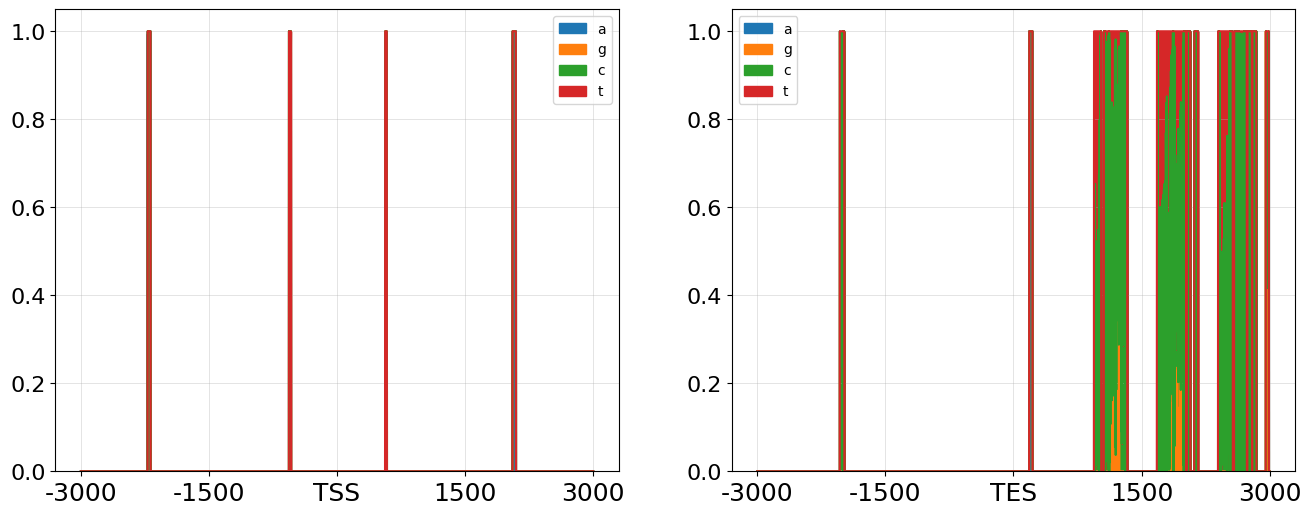

In [131]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i, site in enumerate(["start", "end"]):
    logos_df = pd.DataFrame(logos_pn[site])
    logos_df.loc[:, "total"] = logos_df.sum(axis=1)
    for n in nucleotides:
        logos_df[n] = logos_df[n].div(logos_df['total'])

    logos_df.drop(columns=['total']).plot.area(ax=ax[i],)
    
    ax[i].grid(lw=0.4, alpha=0.6, zorder=0)
    ax[i].set_xlabel("")
    ax[i].tick_params(which="major", labelsize=16,)
    ax[i].tick_params(axis="x", which="major", labelsize=18)
    # ax[i].legend(frameon=False, handles=[])
    ax[i].set_xticks(range(0, window*2+500, window//2), [f'{j-window}' if j != window else ('TSS' if i == 0 else 'TES') for j in range(0, window*2+500, window//2)])